In [101]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium as fo
import selenium
import numpy as np
import datetime
from scipy.interpolate import interp1d
import json

%matplotlib inline
pd.set_option('mode.chained_assignment', None)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.4', 'font.family':'Calibri'})

<a id='presentation'></a>
# VI] Analysis for the Data Story content

# 1) Big franchises VS small independents

# 1.1) Basic differences between franchises and independents
- most common violation types
- distribution of the inspections' types
- differences in the inspections numbers and fail rates

In [15]:
df = pd.read_parquet('resources/extended_dataset.parquet').set_index('Inspection ID')
df.head(1)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,...,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27,[None],0,0,0,0


In [16]:
df['Inspection Type'].unique()

array(['Complaint', 'License', 'Canvass', 'Others',
       'Suspect food poisoning', 'Cancelled', 'Consultation', 'Unknown',
       'Task-force'], dtype=object)

In [17]:
df['Facility Type'].unique()

array(['Restaurant', 'Childrens services facility', 'Daycare (2-6 yo)',
       'Grocery store', 'Daycare (0-6 yo)', 'Liquor store', 'Caterer',
       'Mobile food dispenser', 'Sweetshop', 'Bakery', 'Tavern',
       'Long term care center', 'Unknown', 'Others', 'School',
       'Banquet hall', 'Golden Dinner', 'Hospital', 'Daycare (0-2 yo)',
       'Daycare (others)', 'Gas station', 'Wholesaler', 'Shared kitchen',
       'Rooftop', 'Coffee shop', 'Shelter'], dtype=object)

In [18]:
df['Results'] = df['Results'].map(lambda x: x if x != 'Pass w/ Conditions' else 'Pass')
df['Results'].unique()

array(['Pass', 'Fail', 'Not Ready', 'No Entry', 'Out of Business',
       'Business Not Located'], dtype=object)

In [19]:
facility_types_to_keep = ['Restaurant', 'Coffe shop', 'Tavern', 'Rooftop']
results_to_keep = ['Fail', 'Pass']
old_len = len(df)
df = df.dropna(subset=['AKA Name'])
df = df[df['Re-inspection'] == False]
df = df[df['Facility Type'].map(lambda x: x in facility_types_to_keep)]
df = df[df['Results'].map(lambda x: x in results_to_keep)]
df = df[df['Inspection Type'] != 'Cancelled']
print('We have thrown away {}% of the inspections'.format((1 - len(df)/old_len) * 100))

We have thrown away 54.067467040614716% of the inspections


We need to regroup the aka names representing the same franchises. (ex: McDonals = MacDonals)

In [20]:
def remove_special_chars(string):
    return ''.join(e for e in string if e.isalnum()).upper()

def standardize_names(string):
    if 'MCDONALDS' in string:
        return 'MCDONALDS'
    elif 'SUBWAY' in string:
        return 'SUBWAY'
    elif 'POTBELLYSANDWICH' in string:
        return 'POTBELLYSANDWICH'
    elif 'POPEYES' in string:
        return 'POPEYES'
    elif 'DUNKINDONUTS' in string:
        return 'DUNKINDONUTS'
    elif 'BURGERKING' in string:
        return 'BURGERKING'
    elif 'WENDYS' in string:
        return 'WENDYS'
    elif 'STARBUCKS' in string:
        return 'STARBUCKS'
    elif 'PIZZAHUT' in string:
        return 'PIZZAHUT'
    elif 'KFC' in string or 'KENTUCKYFRIEDCHICKEN' in string:
        return 'KFC'
    elif 'HAROLDSCHICKEN' in string:
        return 'HAROLDSCHICKEN'
    elif '7ELEVEN' in string:
        return '7ELEVEN'
    elif 'JJFISH' in string:
        return 'JJFISH'
    elif 'DOMINOS' in string:
        return 'DOMINOS'
    elif 'CHIPOTLE' in string:
        return 'CHIPOTLE'
    return string

In [21]:
df['AKA Name'] = df['AKA Name'].map(lambda x: standardize_names(remove_special_chars(x)) if x is not None else None)

In [22]:
nb_licenses_by_aka_dict = {}
for name in df['AKA Name'].unique():
    nb_uniques = len(df[df['AKA Name'] == name].groupby('License #'))
    nb_licenses_by_aka_dict[name] = nb_uniques

In [23]:
nb_licenses_by_aka = pd.DataFrame(nb_licenses_by_aka_dict.items(), columns=['AKA Name', 'Nb Licenses']).set_index('AKA Name').sort_values('Nb Licenses', ascending=False)
nb_licenses_by_aka.head(10)

,Nb Licenses
AKA Name,
SUBWAY,393
DUNKINDONUTS,270
STARBUCKS,240
MCDONALDS,175
BURGERKING,102
KFC,83
HAROLDSCHICKEN,68
POPEYES,58
PIZZAHUT,57


In [24]:
nb_inspections_by_aka = df[['AKA Name', 'DBA Name']].groupby('AKA Name').count().rename(columns={'DBA Name' : 'Nb Inspections'}).sort_values('Nb Inspections', ascending=False)
nb_passed_inspections_by_aka = df[df['Results'] == 'Pass'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Passed Inspections'})
nb_failed_inspections_by_aka = df[df['Results'] == 'Fail'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Failed Inspections'})
mean_nb_violations_by_aka = df[['AKA Name', 'Nb Violations']].groupby('AKA Name').mean().rename(columns={'Nb Violations' : 'Mean Nb Violations'})
mean_nb_high_violations_by_aka = df[['AKA Name', 'Nb Violations of high severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of high severity' : 'Mean Nb Violations of high severity'})
mean_nb_medium_violations_by_aka = df[['AKA Name', 'Nb Violations of medium severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of medium severity' : 'Mean Nb Violations of medium severity'})
mean_nb_low_violations_by_aka = df[['AKA Name', 'Nb Violations of low severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of low severity' : 'Mean Nb Violations of low severity'})

In [25]:
def retrieve_violation_ids(serie):
    result = {}
    for violation_ids in serie:
        for violation_id in violation_ids:
            if violation_id != 'None':
                violation_id = int(violation_id)
                if violation_id in result:
                    result[violation_id] += 1
                else:
                    result[violation_id] = 1
    return collections.OrderedDict(sorted(result.items()))

violations_ids_by_aka = df[['AKA Name', 'Violation IDs']].groupby('AKA Name').agg(lambda x: retrieve_violation_ids(x)).rename(columns={'Violation IDs' : 'Dist Violation IDs'})
violations_ids_by_aka.head()

,Dist Violation IDs
AKA Name,
1000LIQUORSBIGCITYTAP,"{3: 1, 4: 1, 5: 1, 10: 1, 12: 1, 16: 3, 21: 1,..."
10PINBOWLINGLOUNGE,"{2: 2, 3: 1, 4: 1, 5: 1, 10: 1, 16: 1, 18: 1, ..."
1104WABASH,"{34: 1, 35: 1, 38: 2}"
111COFFEEBAR,"{2: 1, 3: 2, 5: 1, 23: 1, 36: 1, 37: 1, 47: 1,..."
111THSTREETOTB,"{2: 1, 3: 1, 11: 1, 18: 2, 30: 2, 31: 1, 32: 3..."


In [26]:
def retrieve_inspections_types(serie):
    result = {}
    for inspection_type in serie:
        if inspection_type in result:
            result[inspection_type] += 1
        else:
            result[inspection_type] = 1
    return collections.OrderedDict(sorted(result.items()))
    
inspections_types_by_aka = df[['AKA Name', 'Inspection Type']].groupby('AKA Name').agg(lambda x: retrieve_inspections_types(x)).rename(columns={'Inspection Type' : 'Dist Inspections Types'})
inspections_types_by_aka.head()

,Dist Inspections Types
AKA Name,
1000LIQUORSBIGCITYTAP,"{'Canvass': 6, 'Complaint': 4}"
10PINBOWLINGLOUNGE,"{'Canvass': 7, 'Complaint': 2}"
1104WABASH,"{'Complaint': 1, 'License': 2}"
111COFFEEBAR,{'License': 2}
111THSTREETOTB,"{'Canvass': 5, 'Complaint': 1, 'Task-force': 2}"


In [28]:
df_joined = nb_inspections_by_aka.join(nb_licenses_by_aka).join(nb_passed_inspections_by_aka.join(nb_failed_inspections_by_aka)).join(mean_nb_violations_by_aka.join(mean_nb_high_violations_by_aka).join(mean_nb_medium_violations_by_aka).join(mean_nb_low_violations_by_aka)).join(violations_ids_by_aka).join(inspections_types_by_aka)
df_joined['Mean Nb Inspections'] = df_joined['Nb Inspections'] / df_joined['Nb Licenses']
df_joined['Mean Percent Passed Inspections'] = ((df_joined['Nb Passed Inspections'] / df_joined['Nb Licenses']) / df_joined['Mean Nb Inspections'] * 100).fillna(0.0)
df_joined['Mean Percent Failed Inspections'] = 100 - df_joined['Mean Percent Passed Inspections']
df_joined = df_joined.drop(['Nb Passed Inspections', 'Nb Failed Inspections'], axis=1)

def size_category(nb_addresses):
    if nb_addresses >= 100:
        return 'Huge'
    if nb_addresses >= 20:
        return 'Large'
    elif nb_addresses >= 5:
        return 'Medium'
    else:
        return 'Small'
    
df_joined['Size'] = df_joined['Nb Licenses'].map(size_category)

df_joined.head(5)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
SUBWAY,3239,393,2.931460,0.354122,0.332819,2.244520,"{1: 24, 2: 162, 3: 448, 4: 11, 5: 191, 6: 53, ...","{'Canvass': 2385, 'Complaint': 571, 'Consultat...",8.241730,83.976536,16.023464,Huge
DUNKINDONUTS,1831,270,3.416712,0.294921,0.364828,2.756963,"{1: 12, 2: 89, 3: 164, 4: 3, 5: 62, 6: 52, 7: ...","{'Canvass': 1049, 'Complaint': 632, 'Consultat...",6.781481,80.939377,19.060623,Huge
MCDONALDS,1606,175,3.415940,0.262765,0.283313,2.869863,"{1: 2, 2: 60, 3: 122, 4: 7, 5: 37, 6: 30, 7: 1...","{'Canvass': 407, 'Complaint': 1093, 'Consultat...",9.177143,78.767123,21.232877,Huge
STARBUCKS,1107,240,2.368564,0.178862,0.228546,1.961156,"{1: 5, 2: 25, 3: 58, 4: 2, 5: 41, 6: 3, 8: 17,...","{'Canvass': 824, 'Complaint': 125, 'Consultati...",4.612500,85.275519,14.724481,Huge
BURGERKING,545,102,3.823853,0.308257,0.390826,3.124771,"{1: 2, 2: 13, 3: 50, 4: 2, 5: 30, 6: 10, 7: 1,...","{'Canvass': 159, 'Complaint': 315, 'License': ...",5.343137,79.816514,20.183486,Huge


## What is the distribution of the size categories ? ##

,Dist Size
Size,
Huge,5
Large,17
Medium,227
Small,11973


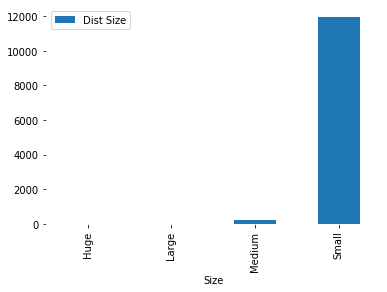

In [31]:
df_sizes = df_joined[['Size', 'Nb Inspections']].groupby('Size').count().rename(columns={'Nb Inspections' : 'Dist Size'})
df_sizes.plot.bar()
df_sizes

Most of the restaurants are independent. We have a power law.

In [32]:
df_joined.groupby('Size').median()

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections
Size,,,,,,,,,
Huge,1606,240,3.415940,0.294921,0.332819,2.756963,6.781481,80.939377,19.060623
Large,216,47,3.268966,0.305263,0.372470,2.512953,5.363636,79.096045,20.903955
Medium,23,6,3.538462,0.416667,0.400000,2.758621,3.333333,77.777778,22.222222
Small,4,1,4.250000,0.333333,0.333333,3.400000,3.000000,77.777778,22.222222


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


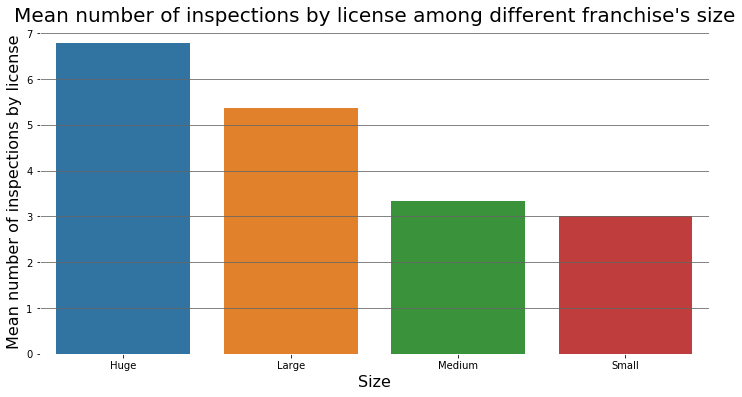

In [33]:
nb_inspections_by_size = df_joined[['Size', 'Mean Nb Inspections']].groupby('Size').median()

fig, ax = plt.subplots(1, 1, figsize=(12,6))

bar = sns.barplot(x='Size', y='Mean Nb Inspections', data=nb_inspections_by_size.reset_index(), ax=ax)
bar.set_title("Mean number of inspections by license among different franchise's size", fontsize=20)
bar.set_xlabel("Size", fontsize=16)
bar.set_ylabel('Mean number of inspections by license', fontsize=16)
bar.grid(axis='y')

fig.savefig('results/figures_aka/nb_inspections_by_size.png', bbox_inches='tight')

Here we see that in average, big franchises tend to have more inspections by license.

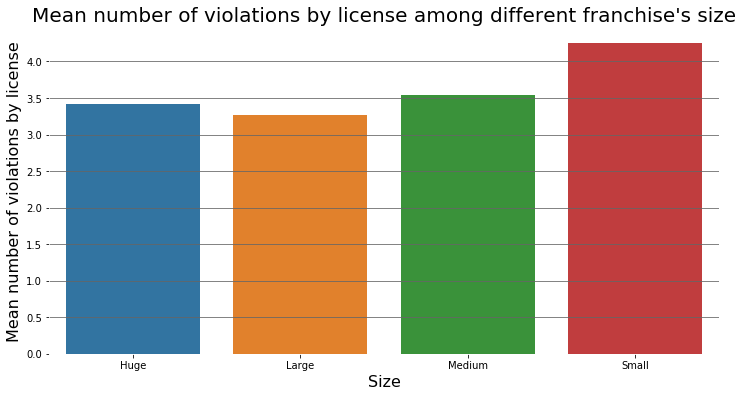

In [66]:
nb_violations_by_size = df_joined[['Size', 'Mean Nb Violations']].groupby('Size').median()

fig, ax = plt.subplots(1, 1, figsize=(12,6))

bar = sns.barplot(x='Size', y='Mean Nb Violations', data=nb_violations_by_size.reset_index(), ax=ax)
bar.set_title("Mean number of violations by license among different franchise's size", fontsize=20)
bar.set_xlabel("Size", fontsize=16)
bar.set_ylabel('Mean number of violations by license', fontsize=16)
bar.grid(axis='y')

fig.savefig('results/figures_aka/nb_violations_by_size.png', bbox_inches='tight')

Small franchises and independents maybe have less inspections by license in average but tend to have more violations by inspection.

## Which ones have more addresses ? ##

In [67]:
df_joined.sort_values('Nb Licenses', ascending=False).head(5)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
SUBWAY,3239,393,2.931460,0.354122,0.332819,2.244520,"{1: 24, 2: 162, 3: 448, 4: 11, 5: 191, 6: 53, ...","{'Canvass': 2385, 'Complaint': 571, 'Consultat...",8.241730,83.976536,16.023464,Huge
DUNKINDONUTS,1831,270,3.416712,0.294921,0.364828,2.756963,"{1: 12, 2: 89, 3: 164, 4: 3, 5: 62, 6: 52, 7: ...","{'Canvass': 1049, 'Complaint': 632, 'Consultat...",6.781481,80.939377,19.060623,Huge
STARBUCKS,1107,240,2.368564,0.178862,0.228546,1.961156,"{1: 5, 2: 25, 3: 58, 4: 2, 5: 41, 6: 3, 8: 17,...","{'Canvass': 824, 'Complaint': 125, 'Consultati...",4.612500,85.275519,14.724481,Huge
MCDONALDS,1606,175,3.415940,0.262765,0.283313,2.869863,"{1: 2, 2: 60, 3: 122, 4: 7, 5: 37, 6: 30, 7: 1...","{'Canvass': 407, 'Complaint': 1093, 'Consultat...",9.177143,78.767123,21.232877,Huge
BURGERKING,545,102,3.823853,0.308257,0.390826,3.124771,"{1: 2, 2: 13, 3: 50, 4: 2, 5: 30, 6: 10, 7: 1,...","{'Canvass': 159, 'Complaint': 315, 'License': ...",5.343137,79.816514,20.183486,Huge


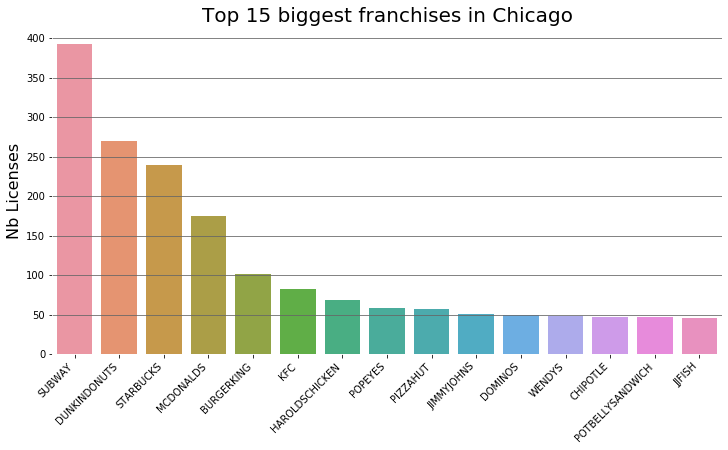

In [68]:
top_15_biggest_franchises = df_joined[['Nb Licenses']].sort_values('Nb Licenses', ascending=False).head(15)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

bar = sns.barplot(x='AKA Name', y='Nb Licenses', data=top_15_biggest_franchises.reset_index(), ax=ax)
bar.set_title("Top 15 biggest franchises in Chicago", fontsize=20)
bar.set_xlabel("", fontsize=16)
bar.set_ylabel('Nb Licenses', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right')
bar.grid(axis='y')

fig.savefig('results/figures_aka/top_15_biggest_franchises.png', bbox_inches='tight')

Here we clearly see which franchises are the most present in chicago.

## Which ones have more inspections in general ? ##

In [69]:
df_joined.sort_values('Mean Nb Inspections', ascending=False).head(5)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
TAQUERIAELRANCHITO,31,1,6.903226,0.645161,0.548387,5.709677,"{1: 1, 2: 4, 3: 8, 4: 2, 6: 1, 8: 2, 9: 1, 11:...","{'Canvass': 4, 'Complaint': 24, 'Others': 1, '...",31.0,67.741935,32.258065,Small
RESTAURANTPOZOLERIASANJUAN,29,1,4.482759,0.172414,0.275862,4.034483,"{3: 1, 5: 2, 10: 2, 16: 1, 18: 2, 22: 1, 23: 1...","{'Canvass': 6, 'Complaint': 23}",29.0,86.206897,13.793103,Small
STAROFSIAM,28,1,4.500000,0.214286,0.357143,3.928571,"{2: 1, 3: 2, 5: 1, 8: 1, 12: 1, 16: 2, 18: 6, ...","{'Canvass': 11, 'Complaint': 14, 'Consultation...",28.0,71.428571,28.571429,Small
CHURCHSCHICKEN982,26,1,4.153846,0.384615,0.615385,3.153846,"{1: 1, 2: 1, 3: 2, 6: 1, 10: 3, 12: 2, 18: 5, ...","{'Canvass': 1, 'Complaint': 24, 'Consultation'...",26.0,65.384615,34.615385,Small
MORRISONSRESTAURANT,26,1,5.692308,0.346154,0.653846,4.692308,"{2: 1, 3: 6, 4: 1, 12: 1, 16: 1, 18: 7, 19: 1,...","{'Canvass': 1, 'Complaint': 24, 'License': 1}",26.0,65.384615,34.615385,Small


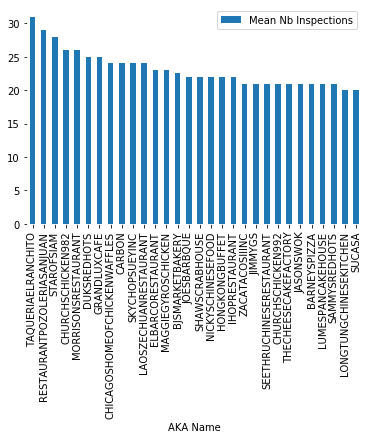

In [70]:
df_joined[['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).head(30).plot.bar()

([], <a list of 0 Text xticklabel objects>)

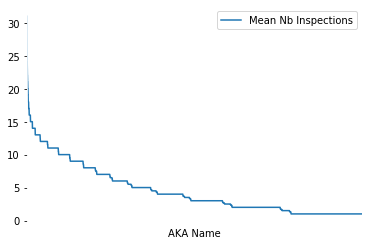

In [71]:
df_joined[['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).plot()
plt.xticks([])

Only a few restaurants have a very big mean number of inspections. Powe law.

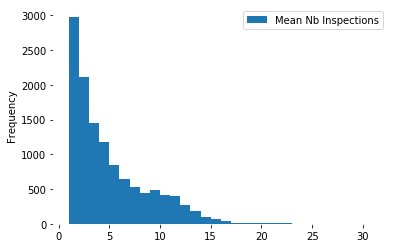

In [72]:
df_joined[['Mean Nb Inspections']].plot.hist(bins=30)

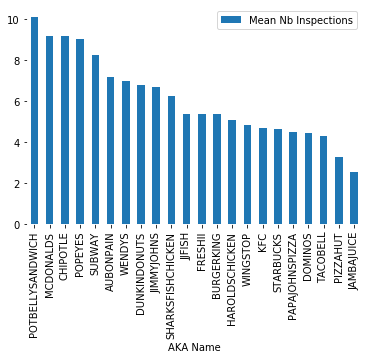

In [73]:
df_joined[df_joined['Size'].map(lambda x: x in ['Huge', 'Large'])][['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).head(30).plot.bar()

## Which ones tend to easily pass inspections ? ##

In [74]:
df_joined.sort_values('Mean Percent Passed Inspections', ascending=False).head(5)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
BELLEMORE,4,2,3.250000,0.750000,0.000000,2.500000,"{2: 1, 3: 1, 8: 1, 30: 1, 35: 3, 38: 2, 41: 3,...","{'Canvass': 1, 'Complaint': 1, 'License': 2}",2.0,100.0,0.0,Small
JOESCOFFEE,3,1,2.000000,0.666667,0.000000,1.333333,"{3: 1, 5: 1, 31: 1, 34: 1, 35: 1, 38: 1}","{'Canvass': 2, 'License': 1}",3.0,100.0,0.0,Small
HOWARDPHILLYGRILLINC,3,1,5.333333,1.000000,0.000000,4.333333,"{3: 1, 4: 1, 12: 1, 30: 1, 33: 2, 34: 2, 35: 2...","{'Canvass': 1, 'Complaint': 2}",3.0,100.0,0.0,Small
NICKOSTACOS,3,1,4.333333,0.000000,0.333333,4.000000,"{21: 1, 30: 1, 31: 1, 32: 1, 34: 2, 35: 1, 38:...","{'Canvass': 2, 'License': 1}",3.0,100.0,0.0,Small
FLETCHERJONESAUDI,3,1,1.000000,0.666667,0.000000,0.333333,"{3: 1, 5: 1, 38: 1}","{'Canvass': 2, 'License': 1}",3.0,100.0,0.0,Small


([], <a list of 0 Text xticklabel objects>)

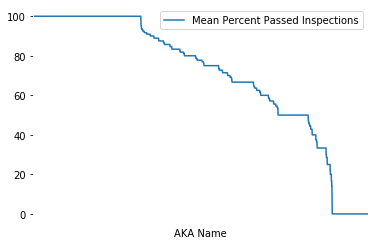

In [75]:
df_joined[['Mean Percent Passed Inspections']].sort_values('Mean Percent Passed Inspections', ascending=False).plot()
plt.xticks([])

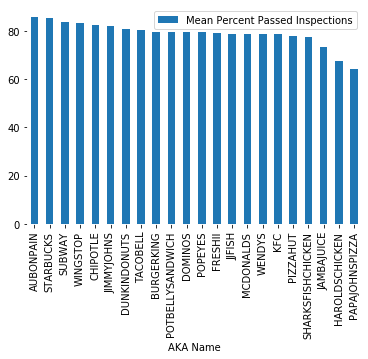

In [76]:
df_joined[df_joined['Size'].map(lambda x: x in ['Huge', 'Large'])][['Mean Percent Passed Inspections']].sort_values('Mean Percent Passed Inspections', ascending=False).head(30).plot.bar()

## Which ones tend to fail inspections ? ##

In [77]:
df_joined.sort_values('Mean Percent Failed Inspections', ascending=False).head(5)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
BROOKLINCHICKENGRILL,1,1,5.0,1.0,1.0,3.0,"{3: 1, 25: 1, 51: 1, 56: 1, 58: 1}",{'License': 1},1.0,0.0,100.0,Small
THEWOODLAWN,1,1,9.0,2.0,0.0,7.0,"{3: 1, 5: 1, 33: 1, 36: 1, 39: 1, 48: 1, 55: 1...",{'License': 1},1.0,0.0,100.0,Small
LATINCORNERRESTAURANT,1,1,4.0,1.0,1.0,2.0,"{2: 1, 18: 1, 34: 1, 38: 1}",{'License': 1},1.0,0.0,100.0,Small
FLAVAFOOD4THESOUL,1,1,7.0,2.0,0.0,5.0,"{3: 1, 5: 1, 36: 1, 38: 1, 48: 1, 56: 1, 58: 1}",{'License': 1},1.0,0.0,100.0,Small
SPLASHCHICAGO,1,1,6.0,1.0,2.0,3.0,"{9: 1, 18: 1, 22: 1, 32: 1, 35: 1, 38: 1}",{'License': 1},1.0,0.0,100.0,Small


([], <a list of 0 Text xticklabel objects>)

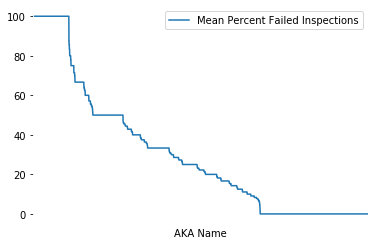

In [78]:
df_joined[['Mean Percent Failed Inspections']].sort_values('Mean Percent Failed Inspections', ascending=False).plot()
plt.xticks([])

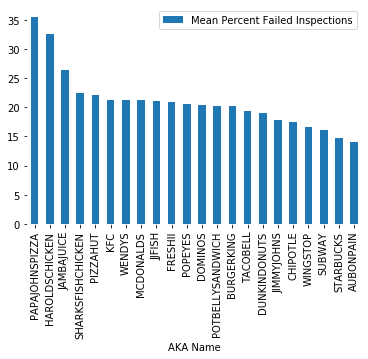

In [79]:
df_joined[df_joined['Size'].map(lambda x: x in ['Huge', 'Large'])][['Mean Percent Failed Inspections']].sort_values('Mean Percent Failed Inspections', ascending=False).head(30).plot.bar()

## Which ones have more violations by inspections ? ##

In [80]:
df_joined.sort_values('Mean Nb Violations', ascending=False).head(5)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
SOULCRABCHICAGO,1,1,24.0,4.0,1.0,19.0,"{1: 1, 2: 1, 3: 1, 5: 1, 22: 1, 36: 1, 37: 1, ...",{'Complaint': 1},1.0,0.0,100.0,Small
BIGBITESUSHI,1,1,23.0,1.0,2.0,20.0,"{3: 1, 16: 1, 25: 1, 33: 1, 36: 1, 39: 1, 47: ...",{'License': 1},1.0,0.0,100.0,Small
DURUMCAFE,1,1,20.0,4.0,3.0,13.0,"{2: 1, 3: 1, 5: 1, 10: 1, 21: 1, 22: 1, 23: 1,...",{'Canvass': 1},1.0,0.0,100.0,Small
VENENOSINC,1,1,20.0,3.0,2.0,15.0,"{3: 1, 5: 1, 10: 1, 22: 1, 23: 1, 33: 1, 38: 1...",{'Canvass': 1},1.0,0.0,100.0,Small
LEPIANO,1,1,20.0,5.0,3.0,12.0,"{1: 1, 2: 1, 3: 1, 5: 1, 10: 1, 16: 1, 23: 1, ...",{'Canvass': 1},1.0,0.0,100.0,Small


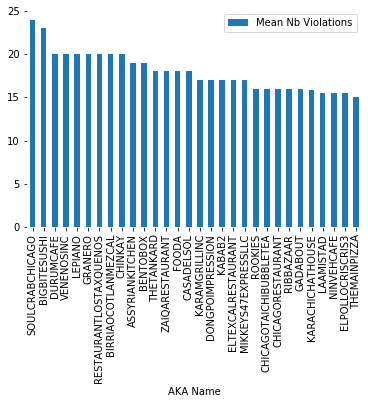

In [81]:
df_joined[['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).head(30).plot.bar()

([], <a list of 0 Text xticklabel objects>)

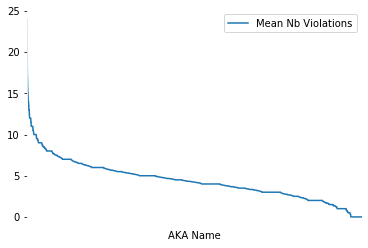

In [82]:
df_joined[['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).plot()
plt.xticks([])

We see that most of the restaurants have between 2 and 7 violations by inspection. A few have a lot more violations. Power law.

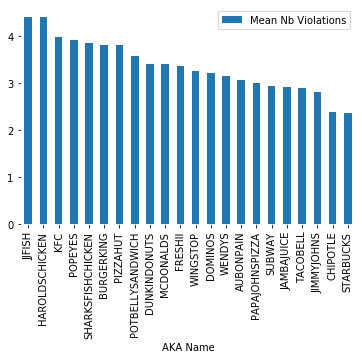

In [83]:
df_joined[df_joined['Size'].map(lambda x: x in ['Huge', 'Large'])][['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).head(30).plot.bar()

## How does the inspections types' distribution change depending on the size ? ##

In [84]:
def normalize_dist(dist):
    result = dist.copy()
    total = sum(dist.values())
    for key in dist.keys():
        result[key] /= total
        result[key] *= 100
    return result

def regroup_inspections_types_dists(dists):
    result = {}
    for dist in dists:
        for key, value in dist.items():
            if key in result:
                result[key] += value
            else:
                result[key] = value
    result = normalize_dist(result)
    return collections.OrderedDict(sorted(result.items()))

In [85]:
interesting_aka_names = ['SUBWAY', 'DUNKINDONUTS', 'STARBUCKS', 'MCDONALDS', 'BURGERKING', 'KFC', 'POPEYES']
list_dists = []
for name in interesting_aka_names:
    dist = normalize_dist(df_joined.loc[name]['Dist Inspections Types'])
    df_dist = pd.DataFrame(dist.items(), columns=['Inspection Type', name]).set_index('Inspection Type')
    list_dists.append(df_dist)

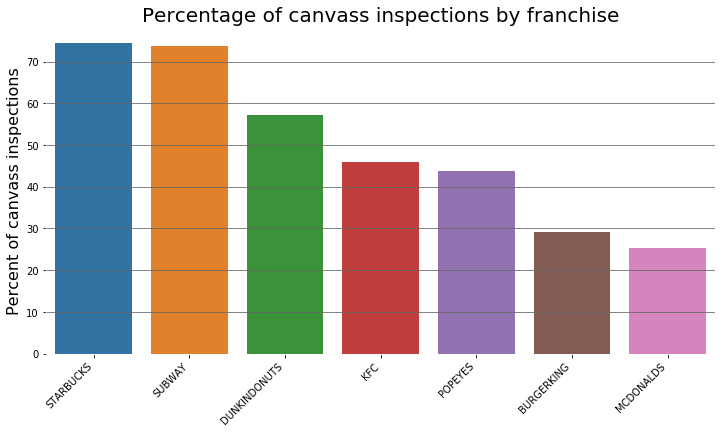

In [86]:
dist_inspections_canvas_by_franchise = pd.concat(list_dists, axis=1, sort=True).loc[['Canvass']].transpose()
dist_inspections_canvas_by_franchise.index.name = 'Franchise'
dist_inspections_canvas_by_franchise = dist_inspections_canvas_by_franchise.sort_values('Canvass', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

bar = sns.barplot(x='Franchise', y='Canvass', data=dist_inspections_canvas_by_franchise.reset_index(), ax=ax)
bar.set_title("Percentage of canvass inspections by franchise", fontsize=20)
bar.set_xlabel("", fontsize=16)
bar.set_ylabel('Percent of canvass inspections', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right')
bar.grid(axis='y')

fig.savefig('results/figures_aka/canvas_inspections_by_franchise.png', bbox_inches='tight')

Starbucks and Subway have an higher percentage of canvass inspections than the others. McDonals for example has mainly complait inspections so its percentage of canvass is low.

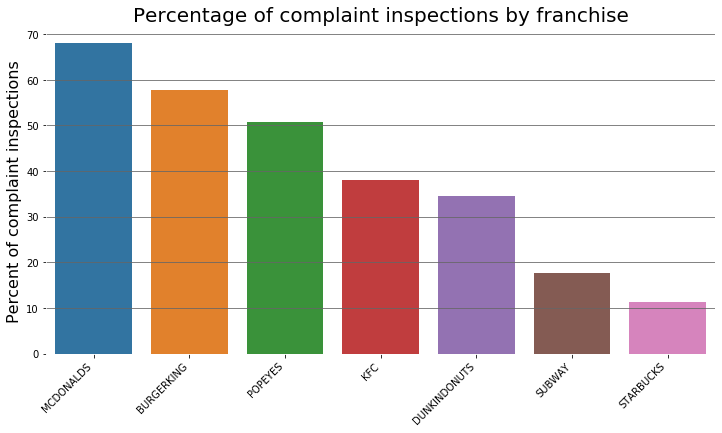

In [87]:
dist_inspections_complaint_by_franchise = pd.concat(list_dists, axis=1, sort=True).loc[['Complaint']].transpose()
dist_inspections_complaint_by_franchise.index.name = 'Franchise'
dist_inspections_complaint_by_franchise = dist_inspections_complaint_by_franchise.sort_values('Complaint', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

bar = sns.barplot(x='Franchise', y='Complaint', data=dist_inspections_complaint_by_franchise.reset_index(), ax=ax)
bar.set_title("Percentage of complaint inspections by franchise", fontsize=20)
bar.set_xlabel("", fontsize=16)
bar.set_ylabel('Percent of complaint inspections', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right')
bar.grid(axis='y')

fig.savefig('results/figures_aka/complaint_inspections_by_franchise.png', bbox_inches='tight')

Here we have quite the opposite than in the last figure. McDonals has an higher percentage of complaint inspections and Starbucks only about 10%.

## How does the violations' distribution change depending on the size ? ##

In [88]:
violations = pd.read_csv('resources/violation-id-meaning.csv').set_index('Violation ID')
violations.head()

,Meaning,Category,Severity
Violation ID,,,
1,Suspicious source,Food safety,High
2,No adequate food storage,Food safety,High
3,Food storage temperature problems,Food safety,High
4,Contamination,Food safety,High
5,Disease among the staff,Hygiene,High


In [89]:
def regroup_violation_dists(dists):
    result = {}
    for dist in dists:
        for key, value in dist.items():
            if key in result:
                result[key] += value
            else:
                result[key] = value
    result = normalize_dist(result)
    return collections.OrderedDict(sorted(result.items()))

def regroup_ids_in_categories(dist, severity=None):
    result = {}
    for key, value in dist.items():
        if key in violations.index:
            key_severity = violations.loc[key]['Severity']
            category = violations.loc[key]['Category']
        else:
            key_severity = 'Small'
            category = 'Other'
        if key_severity == severity or severity is None:
            if category in result:
                result[category] += value
            else:
                result[category] = value
    result = normalize_dist(result)
    return collections.OrderedDict(sorted(result.items()))

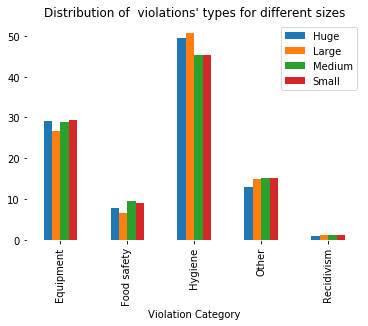

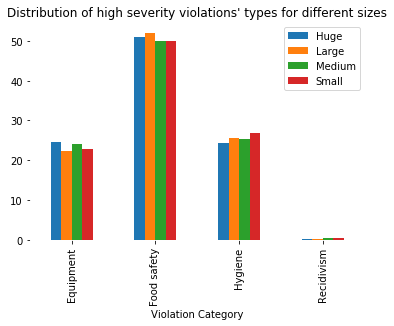

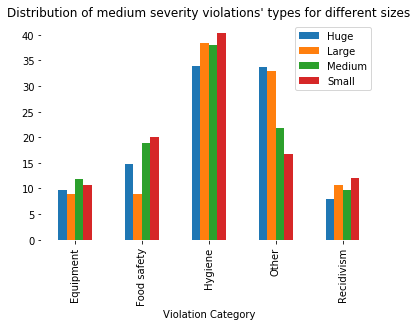

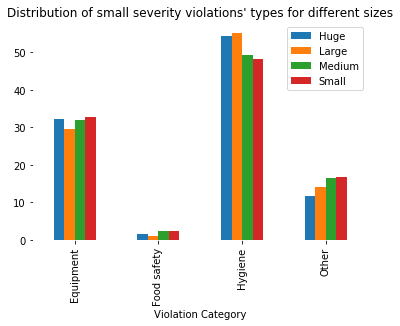

In [90]:
for severity in [None, 'High', 'Medium', 'Small']:
    list_dists = []
    for size in ['Huge', 'Large', 'Medium', 'Small']:
        dist = regroup_violation_dists(df_joined[df_joined['Size'] == size]['Dist Violation IDs'].values)    
        dist_categories = regroup_ids_in_categories(dist, severity=severity)
        df_dist_categories = pd.DataFrame(dist_categories.items(), columns=['Violation Category', size]).set_index('Violation Category')
        list_dists.append(df_dist_categories)
    pd.concat(list_dists, axis=1).plot.bar()
    plt.title("Distribution of {} violations' types for different sizes".format(severity.lower() + " severity" if severity is not None else ''))
    plt.savefig('results/figures_aka/dist_{}_violations_types_by_size.png'.format(severity.lower() if severity is not None else ''), bbox_inches='tight')

We do not see clear significative differences over the violations' types distributions among the franchise's sizes.

## What are the violations distributions for the main ones ? ##

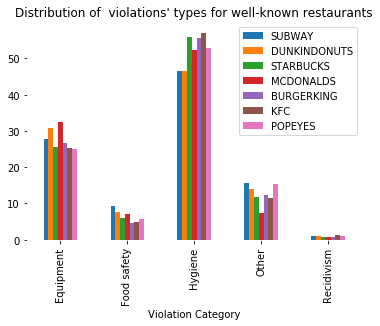

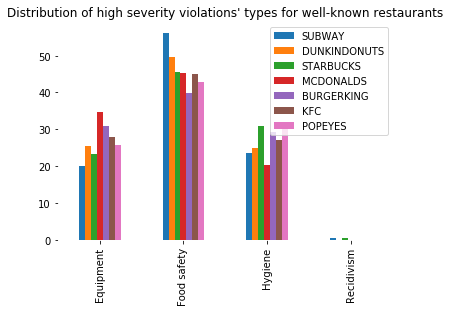

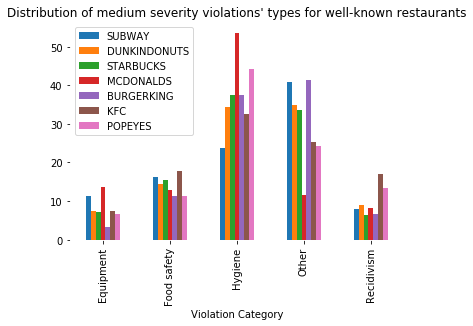

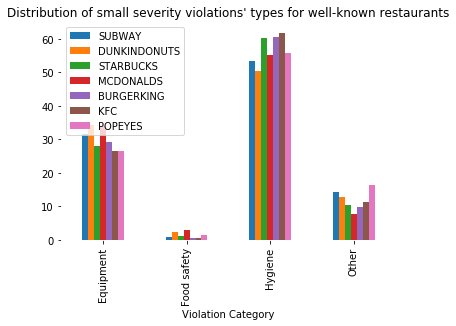

In [91]:
interesting_aka_names = ['SUBWAY', 'DUNKINDONUTS', 'STARBUCKS', 'MCDONALDS', 'BURGERKING', 'KFC', 'POPEYES']
for severity in [None, 'High', 'Medium', 'Small']:
    list_dists = []
    for name in interesting_aka_names:
        dist = df_joined.loc[name]['Dist Violation IDs']
        dist_categories = regroup_ids_in_categories(dist, severity=severity)
        df_dist_categories = pd.DataFrame(dist_categories.items(), columns=['Violation Category', name]).set_index('Violation Category')
        list_dists.append(df_dist_categories)
    pd.concat(list_dists, axis=1, sort=True).plot.bar()
    plt.title("Distribution of {} violations' types for well-known restaurants".format(severity.lower() + " severity" if severity is not None else ''))
    plt.savefig('results/figures_aka/dist_{}_violations_types_by_interesting.png'.format(severity.lower() if severity is not None else ''), bbox_inches='tight')

By looking only at the violations of high severity, we see that Subway has more food safety issues than the others and that McDonnals has a lack of good equipment but less heavy hygiene issues.  
For the violations of medium severity, McDonals has this time more medium hygiene issues than the others. So we can say that McDonals pays attention to not cross the red line regarding hygiene but is close to it.

In [96]:
list_dists = []
for name in interesting_aka_names:
    dist = df_joined.loc[name]['Dist Violation IDs']
    dist_categories = regroup_ids_in_categories(dist, severity='High')
    df_dist_categories = pd.DataFrame(dist_categories.items(), columns=['Violation Category', name]).set_index('Violation Category')
    list_dists.append(df_dist_categories)

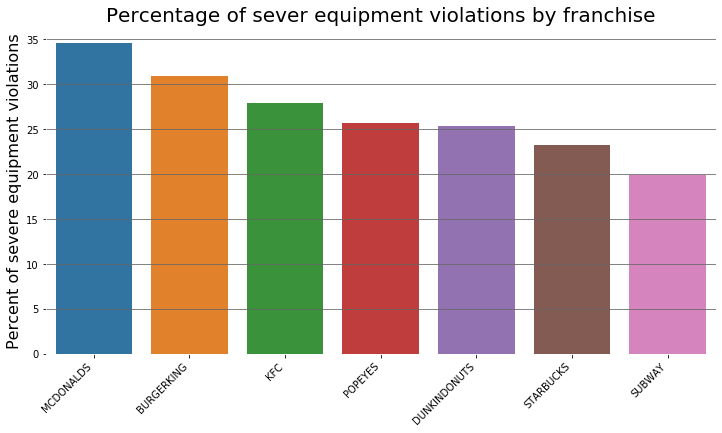

In [97]:
dist_violations_equipment_by_franchise = pd.concat(list_dists, axis=1, sort=True).loc[['Equipment']].transpose()
dist_violations_equipment_by_franchise.index.name = 'Franchise'
dist_violations_equipment_by_franchise = dist_violations_equipment_by_franchise.sort_values('Equipment', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

bar = sns.barplot(x='Franchise', y='Equipment', data=dist_violations_equipment_by_franchise.reset_index(), ax=ax)
bar.set_title("Percentage of sever equipment violations by franchise", fontsize=20)
bar.set_xlabel("", fontsize=16)
bar.set_ylabel('Percent of severe equipment violations', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right')
bar.grid(axis='y')

fig.savefig('results/figures_aka/severe_equipment_violations_by_franchise.png', bbox_inches='tight')

From this figure, McDonals has the highest percentage of severe equipment issues.

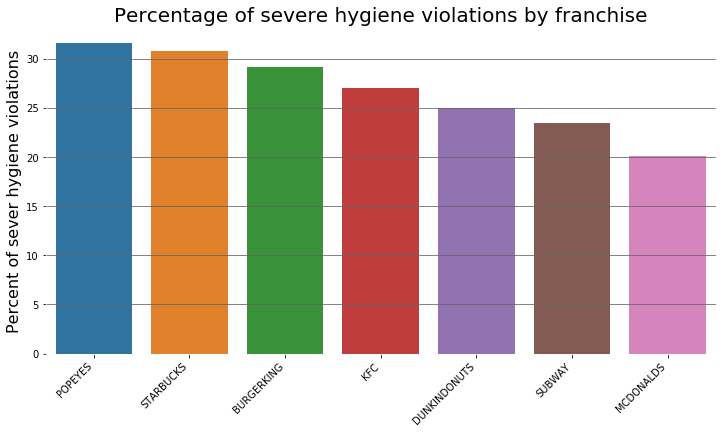

In [98]:
dist_violations_hygiene_by_franchise = pd.concat(list_dists, axis=1, sort=True).loc[['Hygiene']].transpose()
dist_violations_hygiene_by_franchise.index.name = 'Franchise'
dist_violations_hygiene_by_franchise = dist_violations_hygiene_by_franchise.sort_values('Hygiene', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

bar = sns.barplot(x='Franchise', y='Hygiene', data=dist_violations_hygiene_by_franchise.reset_index(), ax=ax)
bar.set_title("Percentage of severe hygiene violations by franchise", fontsize=20)
bar.set_xlabel("", fontsize=16)
bar.set_ylabel('Percent of sever hygiene violations', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right')
bar.grid(axis='y')

fig.savefig('results/figures_aka/severe_hygiene_violations_by_franchise.png', bbox_inches='tight')

Popeys and Starbucks have a higher percentage (more than 30% of their severe violations) of severe hygiene violations.

# 1.2) Analysis about periodicity for the franchises VS the independents
- most common violation types
- distribution of the inspections' types
- differences in the inspections numbers and fail rates

# Violation frequency  
## Violation frequency by violation category  
Regrouping violations in common categories will need less plots while maintening readability and finer analysis.  
To do so, we created 5 categories (food safety, hygiene, equipment, recidivism and others).  
For the analysis, we first map violation's id to their new category and then proceed as usual.

In [112]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
violation_category_mapping.head()

id
1    Food safety
2    Food safety
3    Food safety
4    Food safety
5        Hygiene
Name: category, dtype: object

We also restrict the analysis to certain types of facility: ie restaurants and grocery stores.  

In [113]:
inspections = pd.read_parquet('resources/cleaned_franchises.parquet').rename(columns={'Inspection Date': 'date', 'Nb Violations': 'nb_violations'})
inspections.head(1)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,date,Inspection Type,Results,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,nb_violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2320412,"DANTE'S PIZZA,INC.",DANTESPIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,Fail,...,False,LOGAN SQUARE,LOGAN SQUARE,32,22,"[38, 47, 53, 55, 58, 60]",6,0,0,6


In [114]:
categorized_violations = pd.read_parquet('resources/violations_oriented.parquet').rename(columns={'Violation ID': 'id', 'Inspection Date': 'date'})
categorized_violations.index = categorized_violations.date
categorized_violations['category'] = categorized_violations.id.map(lambda x: violation_category_mapping.get(x))

## Franchise oriented analysis

In [115]:
columns_rename = {'AKA Name': 'name', 'License #': 'license', 'Ward': 'ward', 'Violation IDs': 'violations', 'Inspection Date': 'date', 'Results': 'result', 'Risk': 'risk'}
columns_filter = columns_rename.values()
violations = pd.read_parquet('resources/cleaned_franchises.parquet').rename(columns=columns_rename)[columns_filter]
violations.date = violations.date.map(lambda x: x.year)
violations = violations[(violations.date > 2010) & (violations.date < 2018)]
violations.columns

Index(['name', 'license', 'ward', 'violations', 'date', 'result', 'risk'], dtype='object')

In [116]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique().tolist()
violation_categories.remove('Other')
'Violations categories are: ' + ' - '.join(violation_category_mapping.unique())

'Violations categories are: Food safety - Hygiene - Equipment - Recidivism - Other'

In [122]:
studied_franchises = ['SUBWAY', 'DUNKINDONUTS', 'MCDONALDS',\
                     'STARBUCKS', 'BURGERKING', 'POPEYES',\
                     'POTBELLYSANDWICH', 'CHIPOTLE', 'KFC',\
                     'HAROLDSCHICKEN', 'DOMINOS', 'WENDYS',\
                     'PIZZAHUT', 'AUBONPAIN', 'PAPAJOHNSPIZZA',\
                     'JAMBAJUICE', 'WINGSTOP', 'FRESHII',\
                     'JIMMYJOHNS', 'JJFISH',]
print('We are studying only {} franchises.'.format(len(studied_franchises)))

We are studying only 20 franchises.


## I] Franchises vs the rest of Chicago  
### 1] Average inspections per license 

In [123]:
licenses_per_name = violations[['name', 'license']].groupby(by='name').nunique()[['license']].rename(columns={'license': 'licenses'}).sort_values(by='licenses', ascending=False)
licenses_per_name.head()

,licenses
name,
SUBWAY,355
DUNKINDONUTS,240
STARBUCKS,212
MCDONALDS,153
BURGERKING,100


In [124]:
inspections_per_name = violations.copy()[['name']]
inspections_per_name['inspections'] = 1
inspections_per_name = inspections_per_name.groupby(by='name').count().sort_values(by='inspections', ascending=False)
inspections_per_name.head()

,inspections
name,
SUBWAY,2494
DUNKINDONUTS,1401
MCDONALDS,1157
STARBUCKS,854
BURGERKING,409


In [125]:
avg_inspections_per_license = licenses_per_name.join(inspections_per_name)
avg_inspections_per_license['rate'] = avg_inspections_per_license.inspections / avg_inspections_per_license.licenses
avg_inspections_per_license = avg_inspections_per_license.drop(['inspections', 'licenses'], axis=1)
avg_inspections_per_license['is_franchise'] = avg_inspections_per_license.index.isin(studied_franchises)
avg_inspections_per_license.is_franchise = avg_inspections_per_license.is_franchise.map(lambda x: 'Franchise' if x else 'Individual')

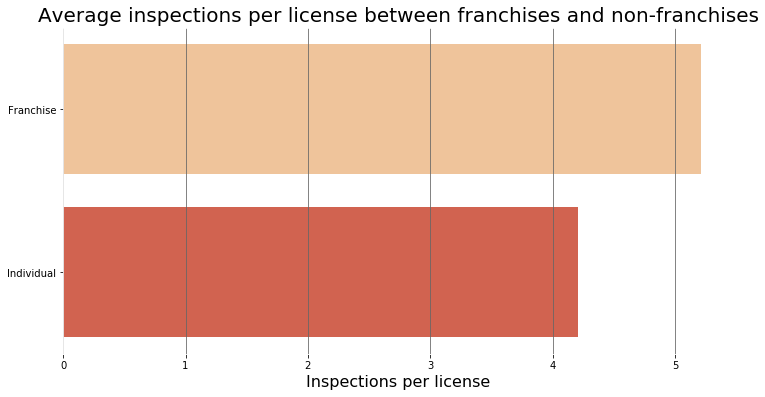

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 2))
bar = sns.barplot(x='rate', y='is_franchise', data=avg_inspections_per_license.groupby(by='is_franchise').mean().reset_index(), ax=ax)
bar.set_title('Average inspections per license between franchises and non-franchises', fontsize=20)
bar.set_xlabel("Inspections per license", fontsize=16)
bar.set_ylabel('', fontsize=16)
bar.grid(axis='x')

fig.savefig('results/figures_frequencies/inspections_avg_franchise_individuals.png')

The franchises we selected are more inspected than the individuals in average.

### 2] Failed inspections

In [127]:
passed_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Results': 'result', 'Inspection Date': 'date'})[['name', 'result', 'date']]
passed_inspections.date = passed_inspections.date.map(lambda x: x.year)
passed_inspections = passed_inspections[(passed_inspections.date > 2010) & (passed_inspections.date < 2018)]
passed_inspections.name = passed_inspections.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
passed_inspections.result = passed_inspections.result.isin(['Fail'])
passed_inspections_rate = passed_inspections.groupby(by=['name', 'date']).mean()
passed_inspections_rate.result = passed_inspections_rate.result * 100
passed_inspections_rate.head()

result
name      date           
Franchise 2011  17.224490
          2012  18.103448
          2013  15.658094
          2014  18.175766
          2015  20.726496

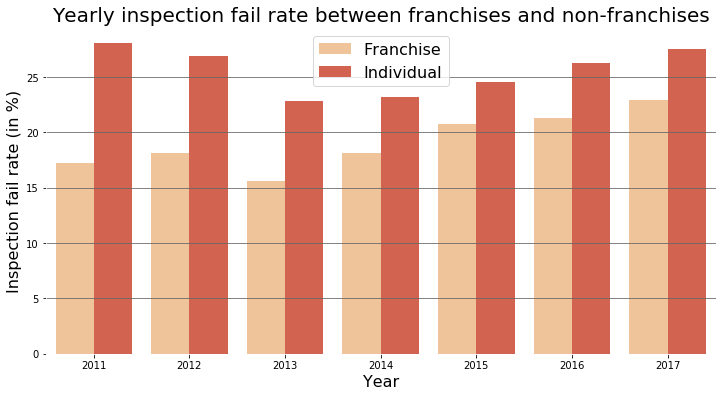

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 2))
bar = sns.barplot(x='date', y='result', hue='name', data=passed_inspections_rate.reset_index(), ax=ax)
bar.set_title('Yearly inspection fail rate between franchises and non-franchises', fontsize=20)
bar.legend(fontsize=16).set_title("")
bar.set_xlabel("Year", fontsize=16)
bar.set_ylabel('Inspection fail rate (in %)', fontsize=16)
bar.grid(axis='y')

fig.savefig('results/figures_frequencies/fail_rate.png')

We see that the fail rate is increasing for the individuals since 2011 (more strict rules we presume). On the other hand, the franchises' fail rate was decreasing until 2014 where it also started to increase.

### 3] Mean number of violations

In [130]:
passed_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Inspection Date': 'date'})[['name', 'nb_violations', 'date']]
passed_inspections.date = passed_inspections.date.map(lambda x: x.year)
passed_inspections = passed_inspections[(passed_inspections.date > 2010) & (passed_inspections.date < 2018)]
passed_inspections.name = passed_inspections.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
passed_inspections_rate = passed_inspections.groupby(by=['name', 'date']).mean()
passed_inspections_rate.head()

nb_violations
name      date               
Franchise 2011       3.253061
          2012       3.235345
          2013       2.923601
          2014       3.070573
          2015       3.259259

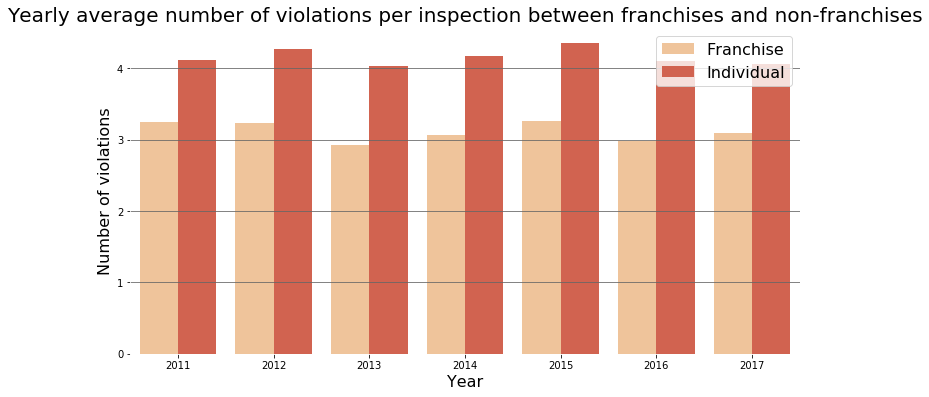

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.set_palette(sns.color_palette("OrRd", 2))

bar = sns.barplot(x='date', y='nb_violations', hue='name', data=passed_inspections_rate.reset_index(), ax=ax)
bar.set_title('Yearly average number of violations per inspection between franchises and non-franchises', fontsize=20)
bar.legend(fontsize=16).set_title("")
bar.set_xlabel("Year", fontsize=16)
bar.set_ylabel('Number of violations', fontsize=16)
bar.grid(axis='y')

fig.savefig('results/figures_frequencies/nb_violations.png')

It is quite constant over the years but in average individuals have more violations by inspection.

### 4] Average types of inspections

In [132]:
type_of_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Inspection Date': 'date', 'Inspection Type': 'type'})[['name', 'type', 'date']]
type_of_inspections.date = type_of_inspections.date.map(lambda x: x.year)
type_of_inspections = type_of_inspections[(type_of_inspections.date > 2010) & (type_of_inspections.date < 2018)]
type_of_inspections.name = type_of_inspections.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
type_of_inspections['count'] = 1

total_inspections = type_of_inspections.drop('type', axis=1).groupby(['name', 'date']).sum()
type_of_inspections_count = type_of_inspections.groupby(by=['name', 'date', 'type']).sum()

type_of_inspection_rate = total_inspections.join(type_of_inspections_count, lsuffix='_total')
type_of_inspection_rate['rate'] = 100 * type_of_inspection_rate['count'] / type_of_inspection_rate['count_total']
type_of_inspection_rate = type_of_inspection_rate.drop(['count_total', 'count'], axis=1).reset_index()
type_of_inspection_rate.head()

,name,date,type,rate
0,Franchise,2011,Canvass,46.122449
1,Franchise,2011,Complaint,40.897959
2,Franchise,2011,Consultation,0.571429
3,Franchise,2011,License,7.673469
4,Franchise,2011,Others,2.775510


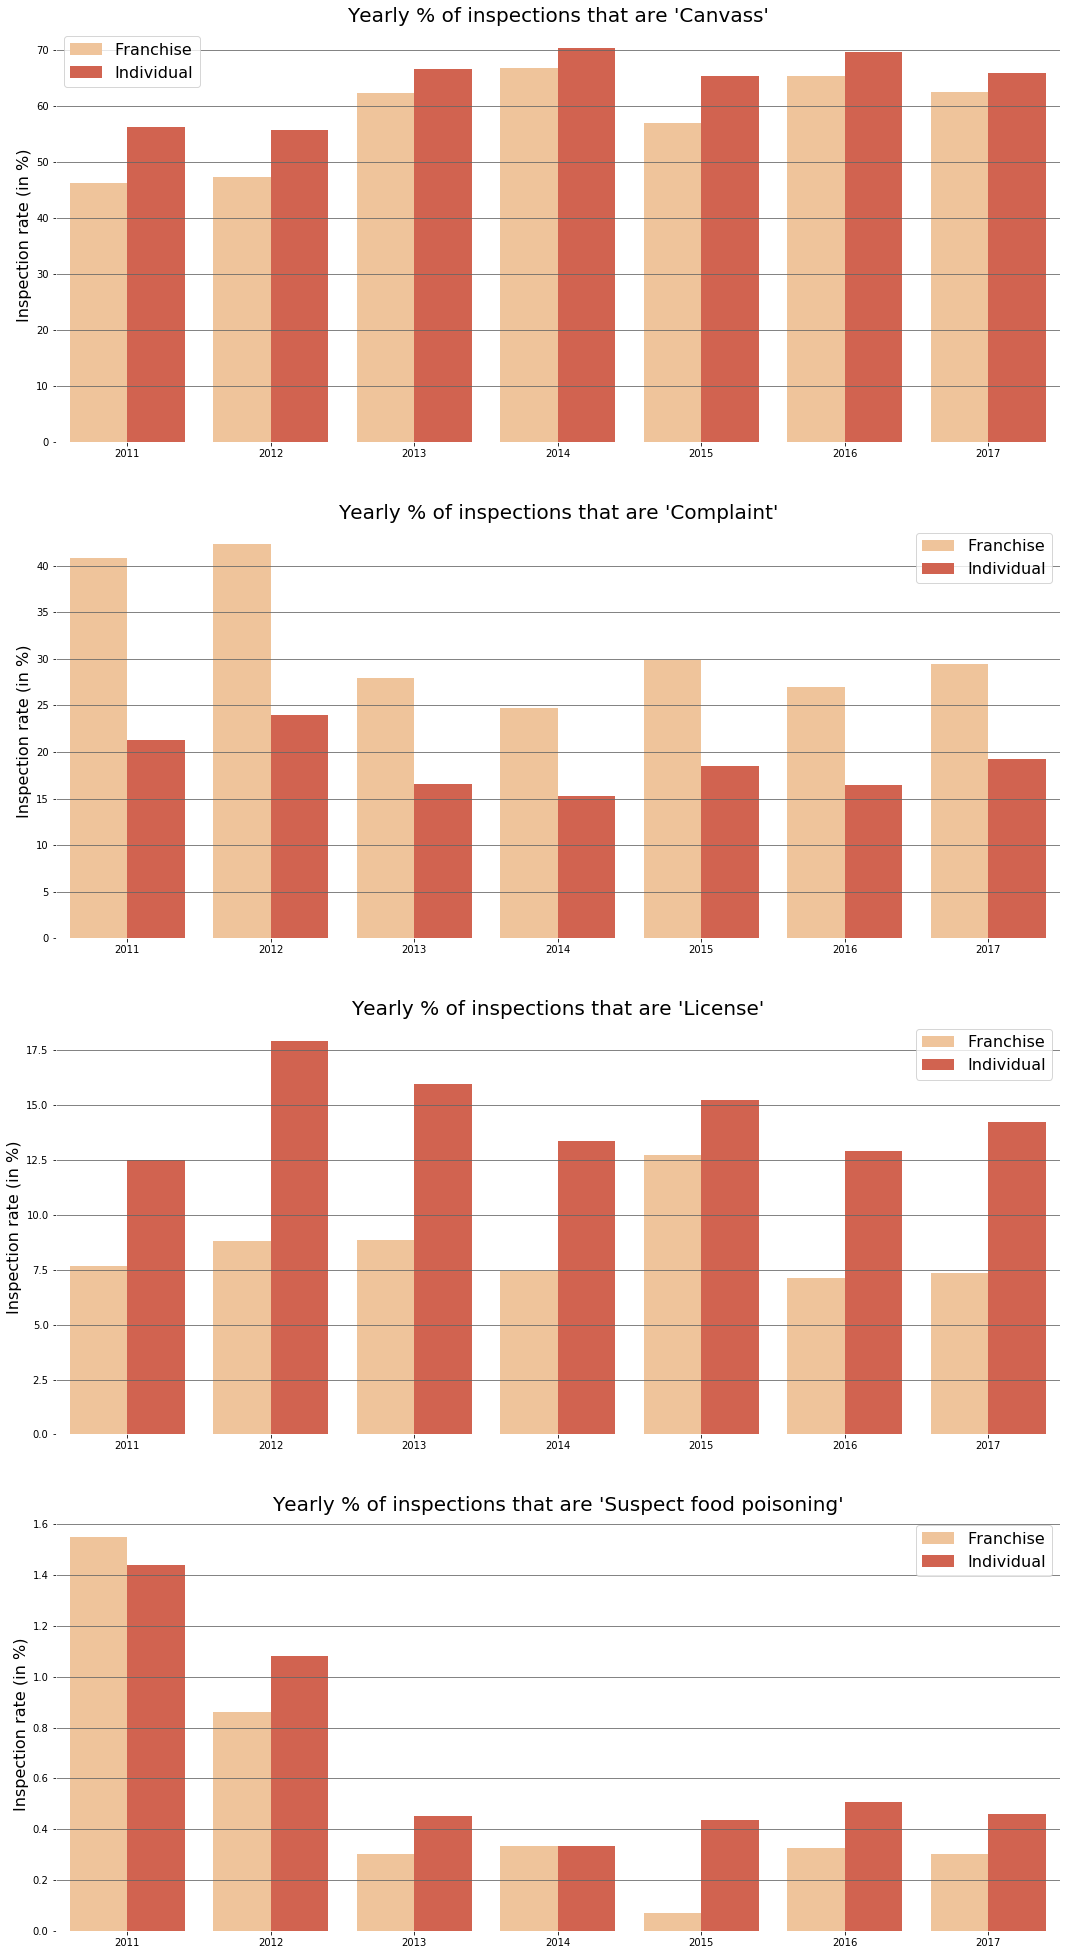

In [133]:
types = ['Canvass', 'Complaint', 'License', 'Suspect food poisoning']
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,35))
sns.set_palette(sns.color_palette("OrRd", 2))

for i, t in enumerate(types):
    filtered = type_of_inspection_rate[type_of_inspection_rate.type == t]
    bar = sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[i])
    bar.set_title('Yearly % of inspections that are \'{}\''.format(t), fontsize=20)
    bar.legend(fontsize=16).set_title("")
    bar.set_xlabel("")
    bar.set_ylabel('Inspection rate (in %)', fontsize=16)
    bar.grid(axis='y')
    
fig.savefig('results/figures_frequencies/inspection_types.png')

Franchises have more complaint than individuals, especially in 2011-2012.  
Obviously, individuals have more 'licenses' inspections.  
The number of 'suspect food poisoning' inspections has greatly reduced since 2011.

### 5] Types of inspections fail rate

In [134]:
type_of_inspections = inspections.copy().rename(columns={'AKA Name': 'name', 'Inspection Date': 'date', 'Inspection Type': 'type', 'Results': 'result'})[['name', 'type', 'date', 'result']]
type_of_inspections.date = type_of_inspections.date.map(lambda x: x.year)
type_of_inspections = type_of_inspections[(type_of_inspections.date > 2010) & (type_of_inspections.date < 2018)]
type_of_inspections.name = type_of_inspections.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
type_of_inspections['rate'] = 100 * (type_of_inspections.result == 'Fail')
type_of_inspections = type_of_inspections.drop('result', axis=1)
type_of_inspections_fail_rate = type_of_inspections.groupby(by=['name', 'date', 'type']).mean().reset_index()
type_of_inspections_fail_rate.head()

,name,date,type,rate
0,Franchise,2011,Canvass,13.982301
1,Franchise,2011,Complaint,16.566866
2,Franchise,2011,Consultation,14.285714
3,Franchise,2011,License,45.744681
4,Franchise,2011,Others,2.941176


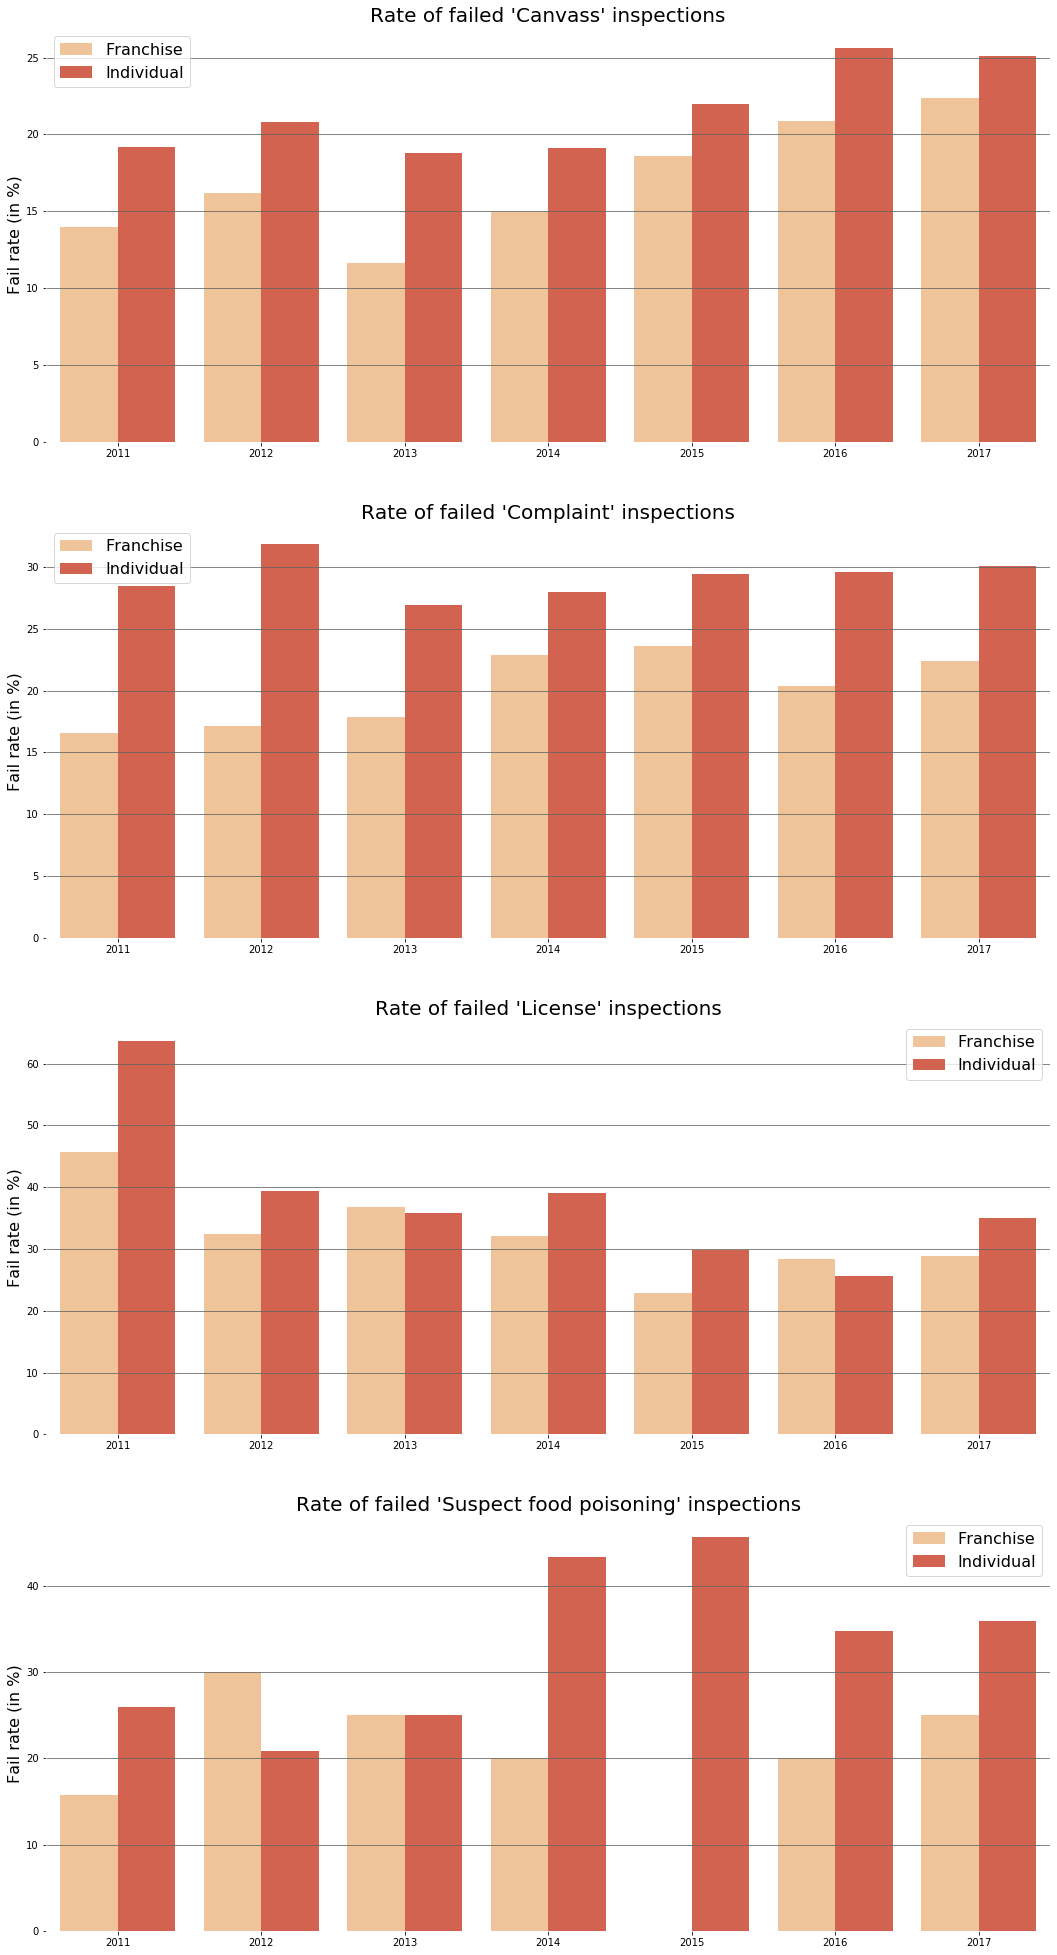

In [135]:
types = ['Canvass', 'Complaint', 'License', 'Suspect food poisoning']
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,35))
sns.set_palette(sns.color_palette("OrRd", 2))

for i, t in enumerate(types):
    filtered = type_of_inspections_fail_rate[type_of_inspections_fail_rate.type == t]
    bar = sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[i])
    bar.set_title('Rate of failed \'{}\' inspections'.format(t), fontsize=20)
    bar.legend(fontsize=16).set_title("")
    bar.set_xlabel("")
    bar.set_ylabel('Fail rate (in %)', fontsize=16)
    bar.grid(axis='y')
    
fig.savefig('results/figures_frequencies/inspection_types_fail_rate.png')

Individuals have a higher 'canvass' fail rate (makes sense).

### 6] Violations categories periodicity

In [137]:
exploded_violations = violations.explode('violations')
exploded_violations = exploded_violations[exploded_violations.violations != 'None']
exploded_violations.violations = exploded_violations.violations.astype('int32').map(lambda x: violation_category_mapping.get(x))
exploded_violations['is_franchise'] = exploded_violations.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
exploded_violations.head(5)

,name,license,ward,violations,date,result,risk,is_franchise
Inspection ID,,,,,,,,
58528,GOSU,2074097,1,Food safety,2011,Fail,High,Individual
58528,GOSU,2074097,1,Hygiene,2011,Fail,High,Individual
58528,GOSU,2074097,1,Other,2011,Fail,High,Individual
58528,GOSU,2074097,1,Hygiene,2011,Fail,High,Individual
58528,GOSU,2074097,1,Equipment,2011,Fail,High,Individual


In [138]:
violation_categories_periodicity = exploded_violations.copy()
violation_categories_periodicity = violation_categories_periodicity[['is_franchise', 'violations', 'date']]
violation_categories_periodicity['v_count'] = 1
violation_categories_periodicity = violation_categories_periodicity.groupby(by=['is_franchise', 'violations', 'date']).sum().reset_index()
violation_categories_periodicity.head()

,is_franchise,violations,date,v_count
0,Franchise,Equipment,2011,1338
1,Franchise,Equipment,2012,1192
2,Franchise,Equipment,2013,1232
3,Franchise,Equipment,2014,1361
4,Franchise,Equipment,2015,1291


We want to normalize this count by the number of inspections.

In [139]:
inspections_per_day_and_franchise = violations.copy()[['name', 'date']]
inspections_per_day_and_franchise['is_franchise'] = inspections_per_day_and_franchise.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
inspections_per_day_and_franchise = inspections_per_day_and_franchise.drop('name', axis=1)
inspections_per_day_and_franchise['i_count'] = 1
inspections_per_day_and_franchise = inspections_per_day_and_franchise.groupby(by=['is_franchise', 'date']).sum()
inspections_per_day_and_franchise.head()

i_count
is_franchise date         
Franchise    2011     1225
             2012     1160
             2013     1322
             2014     1502
             2015     1404

In [140]:
category_rate = inspections_per_day_and_franchise.merge(violation_categories_periodicity, left_on=['is_franchise', 'date'], right_on=['is_franchise', 'date']).rename(columns={'violations': 'category'})
category_rate['rate'] = category_rate.v_count / category_rate.i_count
category_rate = category_rate.drop(['i_count', 'v_count'], axis=1)
category_rate.head()

,is_franchise,date,category,rate
0,Franchise,2011,Equipment,1.092245
1,Franchise,2011,Food safety,0.149388
2,Franchise,2011,Hygiene,1.870204
3,Franchise,2011,Other,0.123265
4,Franchise,2011,Recidivism,0.017959


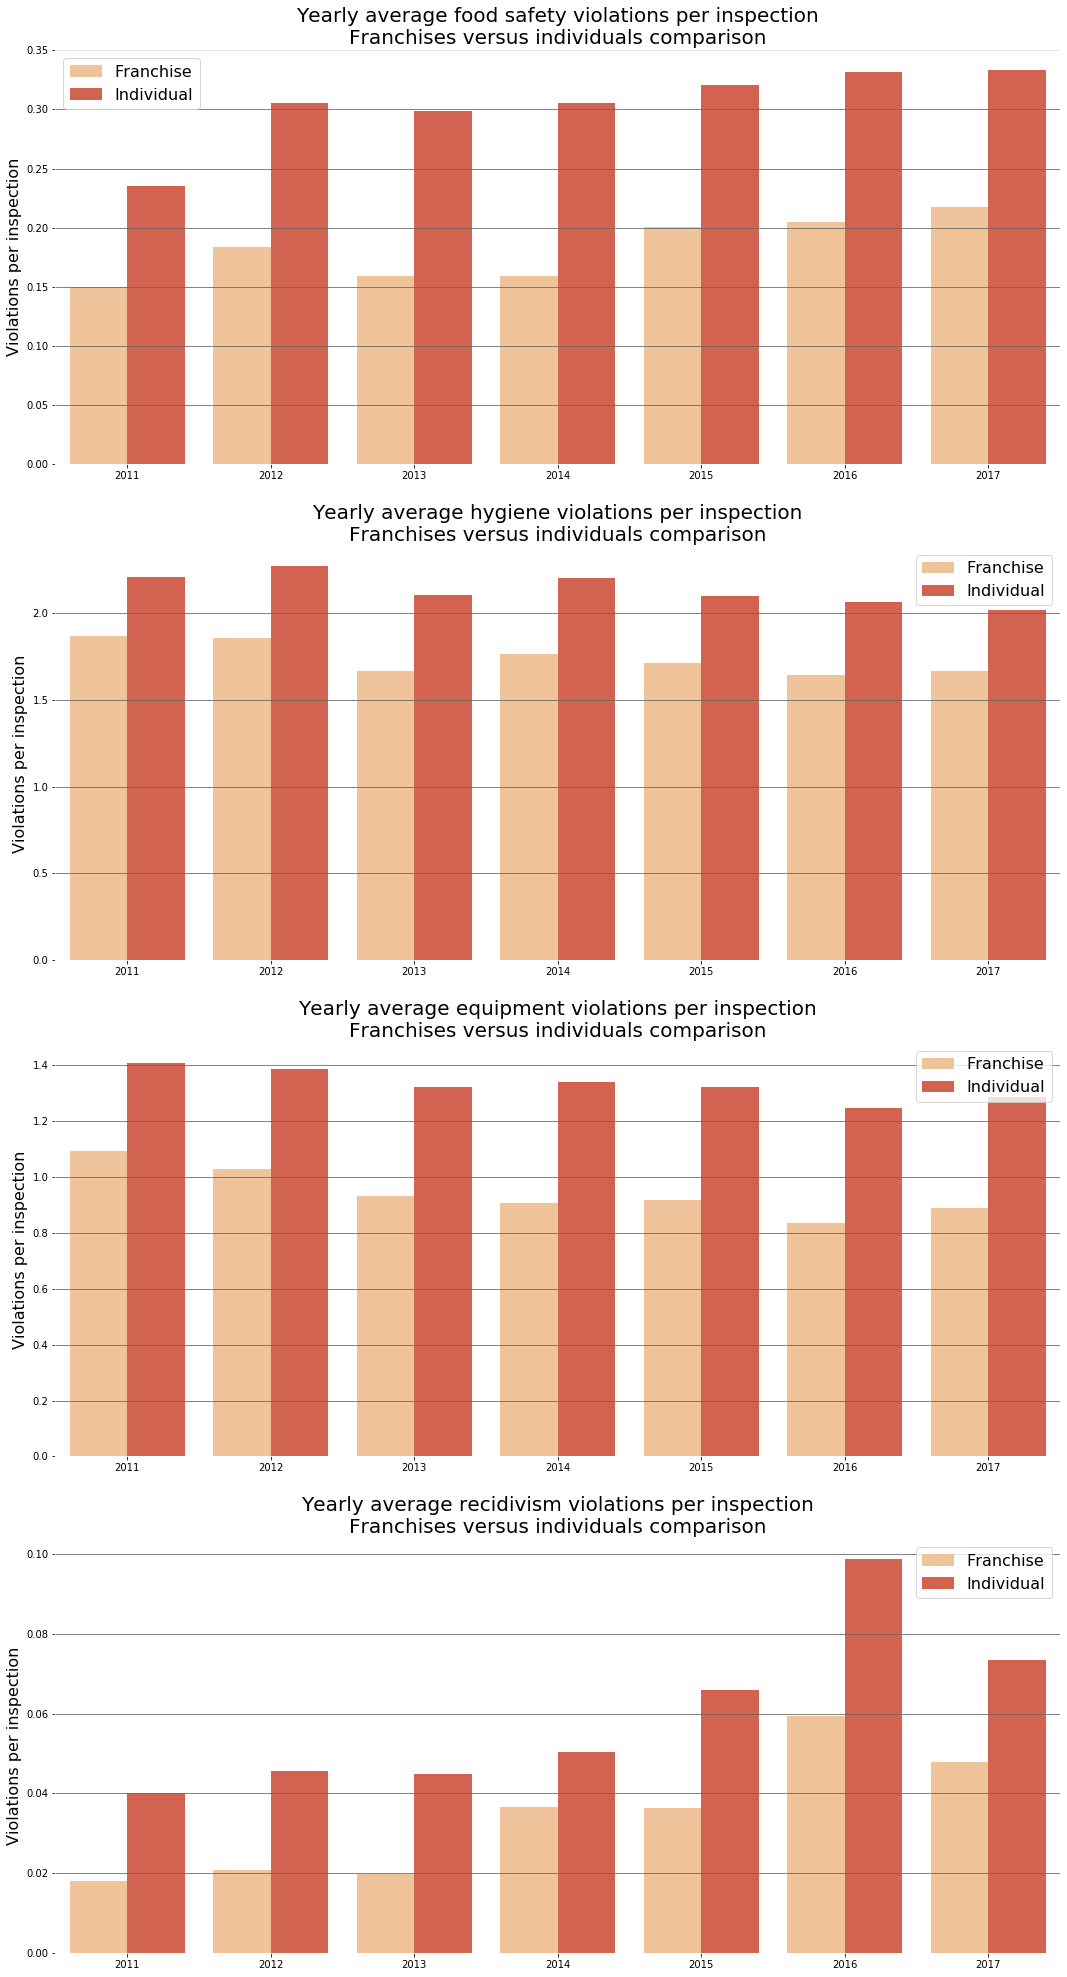

In [141]:
franchises = category_rate.is_franchise.unique()
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,35))
sns.set_palette(sns.color_palette("OrRd", 2))

for i, v_cat in enumerate(violation_categories):
    filtered = category_rate[category_rate.category == v_cat]
    bar = sns.barplot(x='date', y='rate', hue='is_franchise', data=filtered[['date', 'is_franchise', 'rate']], ax=axs[i])
    bar.set_title('Yearly average {} violations per inspection\nFranchises versus individuals comparison'.format(v_cat.lower()), fontsize=20)
    bar.legend(fontsize=16).set_title("")
    bar.set_xlabel("")
    bar.set_ylabel('Violations per inspection', fontsize=16)
    bar.grid(axis='y')
    #axs[i].plot(filtered.date.values, filtered.rate)

fig.savefig('results/figures_frequencies/franchises_vs_individuals.png')

Overall, franchises have less violations by inspections in all the violations' types. It is especially clear about food safety and recidivism.

## II] Franchise groups vs each others  
This time, we will group every franchise in a group (ie: burgers, wraps, ...).  
This may reveal some interesting facts about different franchise types.

In [142]:
def franchise_map(franchise):
    if franchise in ['KFC', 'POPEYES', 'HAROLDSCHICKEN', 'WINGSTOP', 'JJFISH']: return 'Chicken/Fish'
    elif franchise in ['SUBWAY', 'POTBELLYSANDWICH', 'JIMMYJOHNS', 'AUBONPAIN']: return 'Sandwich'
    elif franchise in ['PIZZAHUT', 'DOMINOS', 'PAPAJOHNSPIZZA']: return 'Pizza'
    elif franchise in ['MCDONALDS', 'BURGERKING', 'WENDYS']: return 'Burger'
    elif franchise in ['JAMBAJUICE', 'STARBUCKS']: return 'Drink'
    return 'Other'

### 1] Average inspections per license per group

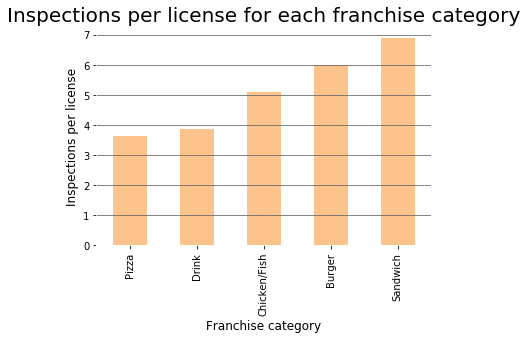

In [143]:
grouped_franchises_licenses = licenses_per_name[licenses_per_name.index.isin(studied_franchises)]
grouped_franchises_licenses.index = grouped_franchises_licenses.index.map(franchise_map)
grouped_franchises_licenses = grouped_franchises_licenses.groupby(by='name').sum()

grouped_franchises_inspections = inspections_per_name[inspections_per_name.index.isin(studied_franchises)]
grouped_franchises_inspections.index = grouped_franchises_inspections.index.map(franchise_map)
grouped_franchises_inspections = grouped_franchises_inspections.groupby(by='name').sum()

inpections_per_license_per_inspection_group = grouped_franchises_licenses.join(grouped_franchises_inspections)
inpections_per_license_per_inspection_group['group'] = inpections_per_license_per_inspection_group.index
inpections_per_license_per_inspection_group['rate'] = inpections_per_license_per_inspection_group.inspections / inpections_per_license_per_inspection_group.licenses
inpections_per_license_per_inspection_group = inpections_per_license_per_inspection_group[inpections_per_license_per_inspection_group.group != 'Other']

bar = inpections_per_license_per_inspection_group.rate.sort_values().plot.bar()
bar.set_title('Inspections per license for each franchise category', fontsize=20)
bar.set_xlabel('Franchise category', fontsize=12)
bar.set_ylabel('Inspections per license', fontsize=12)
bar.grid(axis='y')

Sandwichs and burgers are more inspected.

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

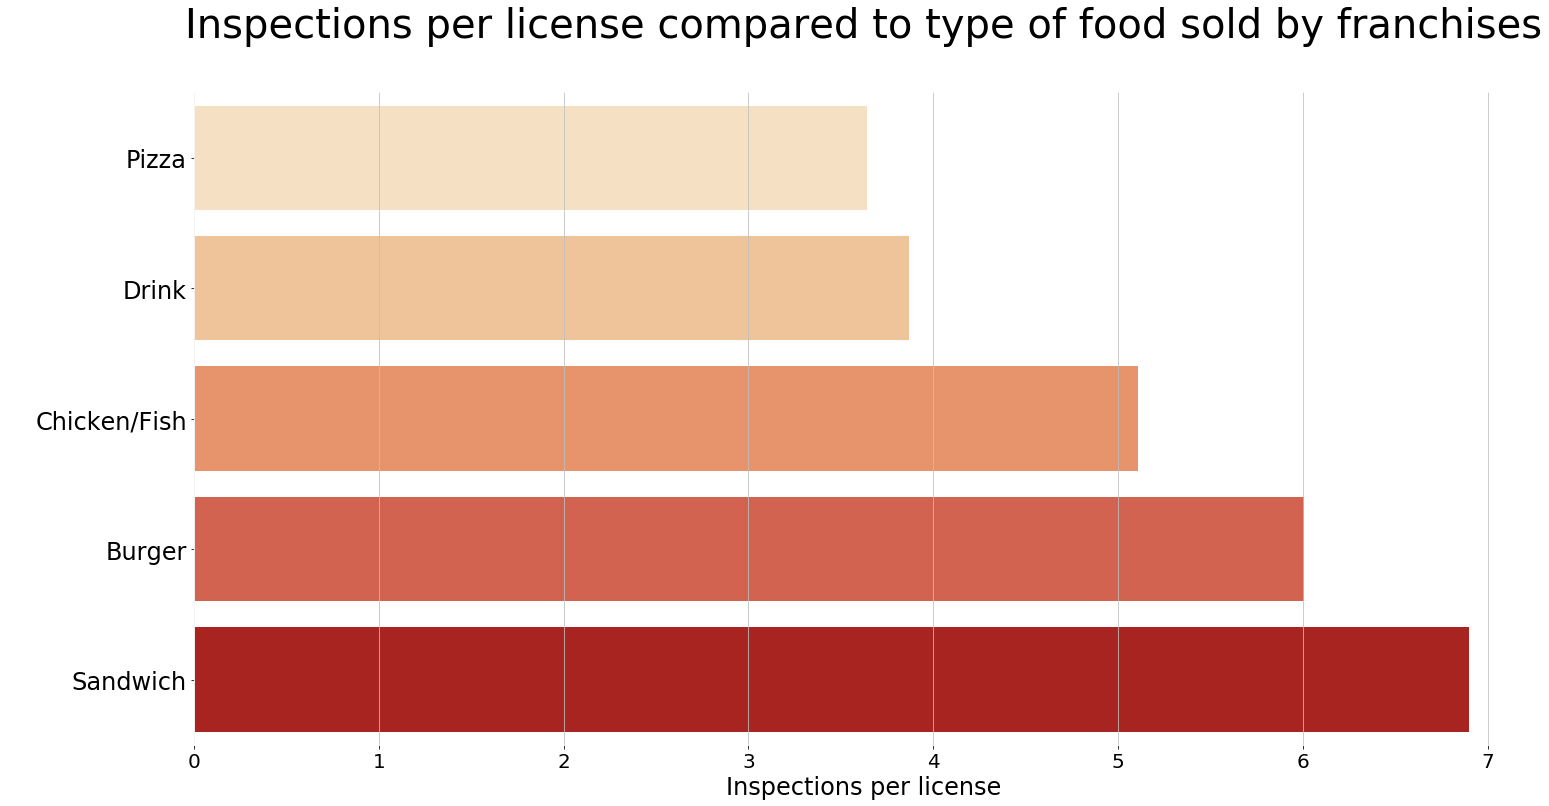

In [144]:
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.set_style({'axes.facecolor':'white','axes.edgecolor': '1', 'grid.color': '0.75', 'font.family':'Calibri'})

fig, ax = plt.subplots(figsize=(24, 12))

sns.set_palette(sns.color_palette("OrRd", 5))
bar = sns.barplot(x="rate", y="group", data=inpections_per_license_per_inspection_group.sort_values('rate'),\
                  label="Total", ax=ax)
bar.set_title('Inspections per license compared to type of food sold by franchises\n', fontsize=40)
bar.set_xlabel('Inspections per license', fontsize=24)
bar.set_ylabel(' ', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)
bar.grid(axis='x')
fig.savefig('results/figures_frequencies/franchisetype_numberofviolations.png')

Clearly, two groups are more controlled than others: burger and sandwich fast foods.  
It contrast with pizza and coffee/milkshake place that are about 30% less inspected.

### 2] Violation average per group

In [145]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]

groups_inspections = franchises_inspections.copy()
groups_inspections.name = groups_inspections.name.map(franchise_map)
groups_inspections.head()

,name,license,ward,violations,date,result,risk
Inspection ID,,,,,,,
2129821,Drink,2398564,42,[37],2017,Pass,Medium
2129808,Other,2391841,5,[21],2017,Pass,Medium
2114246,Burger,2368793,28,[38],2017,Pass,Medium
2114244,Burger,2064662,4,"[34, 35, 36]",2017,Pass,Medium
2129705,Burger,1984911,45,"[6, 34, 35, 38]",2017,Pass,Medium


In [146]:
groups_violations = groups_inspections.explode('violations').rename(columns={'violations': 'id'})
groups_violations.head()

,name,license,ward,id,date,result,risk
Inspection ID,,,,,,,
88637,Sandwich,1357930,49,30,2011,Pass,High
88637,Sandwich,1357930,49,33,2011,Pass,High
88637,Sandwich,1357930,49,34,2011,Pass,High
88637,Sandwich,1357930,49,35,2011,Pass,High
88642,Sandwich,2013950,39,18,2011,Fail,High


In [147]:
violations_per_group = groups_violations[['name', 'id', 'date']]
violations_per_group = violations_per_group[violations_per_group.id != 'None']
violations_per_group['category'] = violations_per_group.id.astype('int32').map(violation_category_mapping.get)
violations_per_group['v_count'] = 1
violations_per_group = violations_per_group.drop('id', axis=1)

violations_per_group_overall = violations_per_group.drop('date', axis=1).groupby(by=['name','category']).sum()
violations_per_group_overall.head()

v_count
name   category            
Burger Equipment       1958
       Food safety      348
       Hygiene         3661
       Other            147
       Recidivism        56

In [148]:
avg_violations_per_group_per_inspection = violations_per_group_overall.join(grouped_franchises_inspections)
avg_violations_per_group_per_inspection['rate'] = avg_violations_per_group_per_inspection.v_count / avg_violations_per_group_per_inspection.inspections
avg_violations_per_group_per_inspection = avg_violations_per_group_per_inspection.drop(['v_count', 'inspections'], axis=1)
avg_violations_per_group_per_inspection.head()

rate
name   category             
Burger Equipment    1.090200
       Food safety  0.193764
       Hygiene      2.038419
       Other        0.081849
       Recidivism   0.031180

In [149]:
avg_violations_per_group_per_inspection.reset_index().pivot(index='name', columns='category', values='rate')

category,Equipment,Food safety,Hygiene,Other,Recidivism
name,,,,,
Burger,1.090200,0.193764,2.038419,0.081849,0.031180
Chicken/Fish,1.120064,0.154714,2.253022,0.202256,0.050766
Drink,0.640131,0.088332,1.418757,0.089422,0.018539
Other,0.990875,0.217391,1.650027,0.219538,0.037037
Pizza,0.904282,0.110831,1.740554,0.307305,0.042821
Sandwich,0.839951,0.201908,1.509080,0.164358,0.033857


### 3] Violation periodicity per group

In [150]:
inspections_per_group_per_day = groups_inspections[['name', 'date']]
inspections_per_group_per_day['i_count'] = 1
inspections_per_group_per_day = inspections_per_group_per_day.groupby(by=['name', 'date']).sum()
inspections_per_group_per_day.head()

i_count
name   date         
Burger 2011      282
       2012      251
       2013      249
       2014      262
       2015      278

In [151]:
violations_per_group_per_day = violations_per_group.copy()
violations_per_group_per_day = violations_per_group_per_day.groupby(by=['name', 'category', 'date']).sum().reset_index('category')
violations_per_group_per_day.head()

category  v_count
name   date                    
Burger 2011  Equipment      388
       2012  Equipment      296
       2013  Equipment      275
       2014  Equipment      292
       2015  Equipment      276

In [152]:
category_rate_per_group = inspections_per_group_per_day.join(violations_per_group_per_day)
category_rate_per_group['rate'] = category_rate_per_group.v_count / category_rate_per_group.i_count
category_rate_per_group = category_rate_per_group.drop(['i_count', 'v_count'], axis=1).reset_index()
category_rate_per_group = category_rate_per_group[category_rate_per_group.name != 'Other']
category_rate_per_group.head()

,name,date,category,rate
0,Burger,2011,Equipment,1.375887
1,Burger,2011,Food safety,0.180851
2,Burger,2011,Hygiene,2.184397
3,Burger,2011,Other,0.046099
4,Burger,2011,Recidivism,0.010638


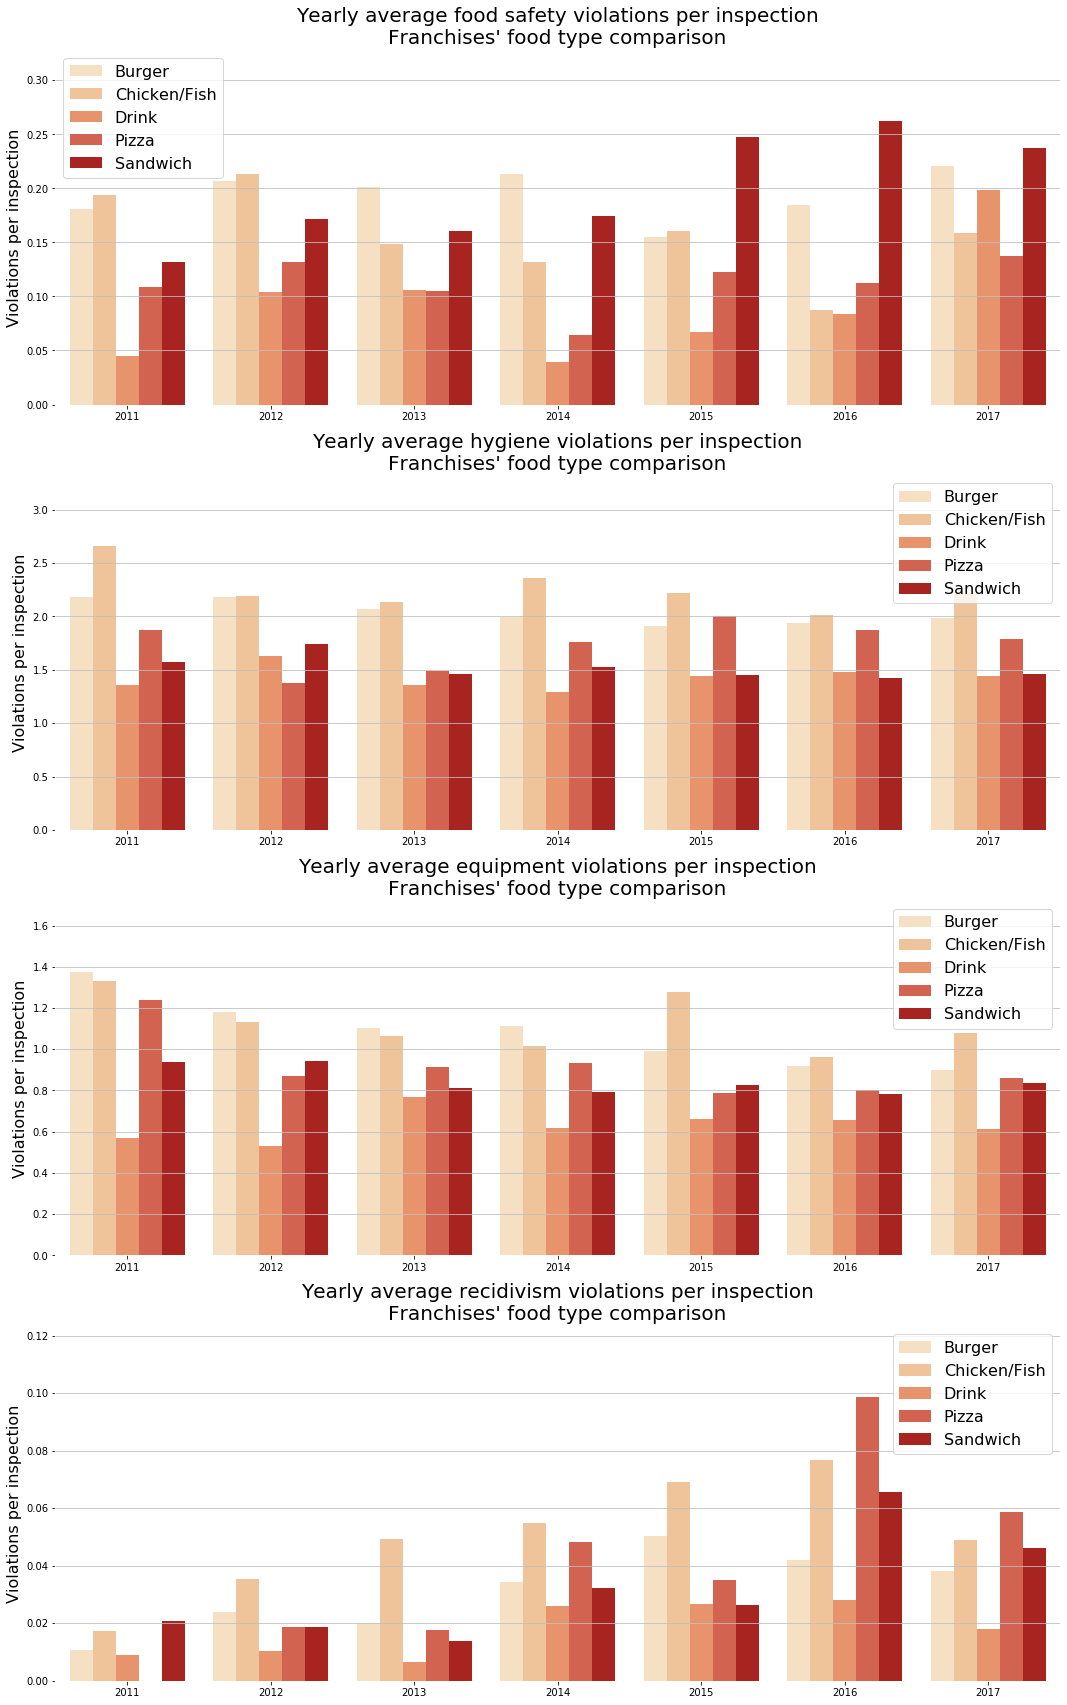

In [153]:
groups = category_rate_per_group.name.unique()
franchises = category_rate.is_franchise.unique()
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,30))
sns.set_palette(sns.color_palette("OrRd", 5))

for i, v_cat in enumerate(violation_categories):
    filtered = category_rate_per_group[category_rate_per_group.category == v_cat]
    bar = sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[i])
    bar.set_title('Yearly average {} violations per inspection\nFranchises\' food type comparison'.format(v_cat.lower()), fontsize=20)
    bar.legend(fontsize=16).set_title("")
    axs[i].set_ylim(0, filtered.rate.values.max() * 1.25)
    bar.set_xlabel("")
    bar.set_ylabel('Violations per inspection', fontsize=16)
    bar.grid(axis='y')
    #axs[i].plot(filtered.date.values, filtered.rate)

fig.savefig('results/figures_frequencies/franchises_types.png')

Since 2015, sandwiches' restaurants have clearly more 'food safety' related inspections.  
Recidivism is increasing over the years but it was especially the case for pizzas' restaurants in 2016-2017.

## II] Franchise group members vs each others

In [154]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]
franchises_inspections['group'] = franchises_inspections.name.map(franchise_map)

inspections_per_franchises = franchises_inspections[['name', 'group', 'date']]
inspections_per_franchises['i_count'] = 1
inspections_per_franchises = inspections_per_franchises.groupby(by=['name', 'group', 'date']).sum()
inspections_per_franchises.head()

i_count
name      group    date         
AUBONPAIN Sandwich 2011       21
                   2012       17
                   2013       25
                   2014       23
                   2015       19

In [155]:
violations_per_franchise = franchises_inspections.explode('violations')
violations_per_franchise = violations_per_franchise[violations_per_franchise.violations != 'None']
violations_per_franchise['category'] = violations_per_franchise.violations.astype('int32').map(violation_category_mapping.get)
violations_per_franchise = violations_per_franchise[['name', 'group', 'category', 'date']]
violations_per_franchise['v_count'] = 1
violations_per_franchise = violations_per_franchise.groupby(by=['name', 'group', 'category', 'date']).sum().reset_index('category')
violations_per_franchise.head()

category  v_count
name      group    date                    
AUBONPAIN Sandwich 2011  Equipment       16
                   2012  Equipment       18
                   2013  Equipment       24
                   2014  Equipment       12
                   2015  Equipment       13

In [156]:
merged = inspections_per_franchises.join(violations_per_franchise)
merged['rate'] = merged.v_count / merged.i_count
merged = merged.drop(['v_count', 'i_count'], axis = 1).reset_index()
merged.head(10)

,name,group,date,category,rate
0,AUBONPAIN,Sandwich,2011,Equipment,0.761905
1,AUBONPAIN,Sandwich,2011,Food safety,0.095238
2,AUBONPAIN,Sandwich,2011,Hygiene,1.619048
3,AUBONPAIN,Sandwich,2012,Equipment,1.058824
4,AUBONPAIN,Sandwich,2012,Food safety,0.352941
5,AUBONPAIN,Sandwich,2012,Hygiene,2.235294
6,AUBONPAIN,Sandwich,2012,Other,0.117647
7,AUBONPAIN,Sandwich,2013,Equipment,0.960000
8,AUBONPAIN,Sandwich,2013,Food safety,0.120000
9,AUBONPAIN,Sandwich,2013,Hygiene,1.520000


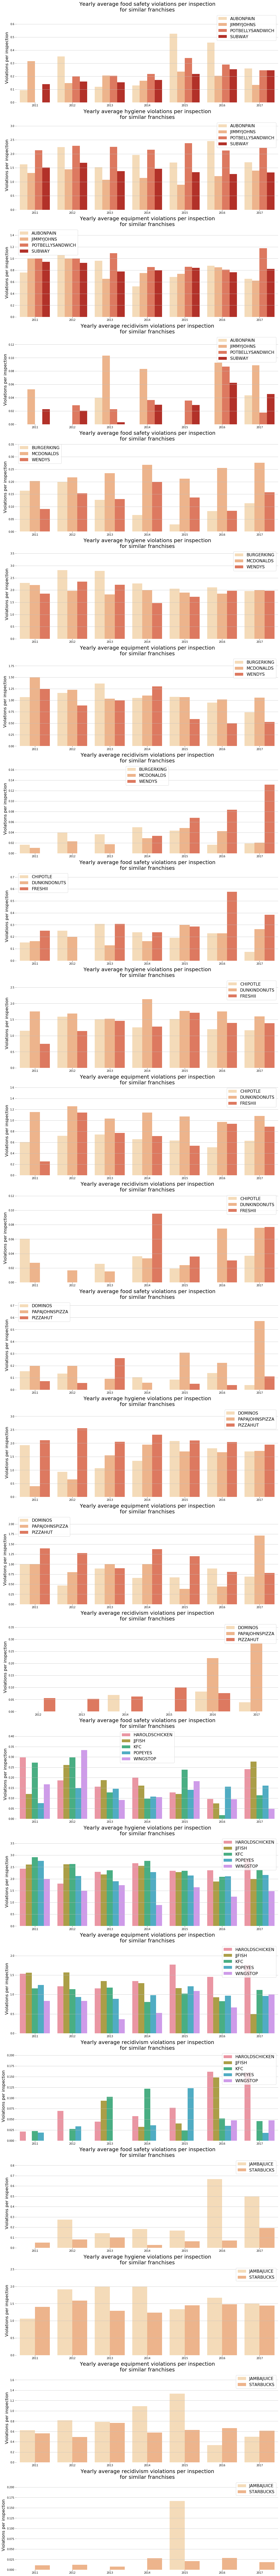

In [157]:
groups = merged.group.unique()
sns.set_palette(sns.color_palette("OrRd", 4))
names = []
for group in groups:
    names.append(merged[merged.group == group].name.unique())
    
fig, axs = plt.subplots(len(violation_categories) * len(groups), 1, figsize=(18,180))

for i, group in enumerate(groups):
    group_rate = merged[merged.group == group]
    
    for k, v_cat in enumerate(violation_categories):
        filtered = group_rate[group_rate.category == v_cat]
        bar = sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[k + i * len(violation_categories)])
        bar.set_title('Yearly average {} violations per inspection\nfor similar franchises'.format(v_cat.lower()), fontsize=20)
        bar.legend(fontsize=16).set_title("")
        bar.set_xlabel("")
        bar.set_ylabel('Violations per inspection', fontsize=16)
        axs[k + i * len(violation_categories)].set_ylim(0, filtered.rate.values.max() * 1.30)
        bar.grid(axis='y')
        #axs[i].plot(filtered.date.values, filtered.rate)
        
fig.savefig('results/figures_frequencies/in_groups_comparison.png')

## IV] Are franchises more concentrated in some areas?  

In [45]:
zips = set(pd.read_parquet('resources/zip_infos.parquet').index.astype('int32').astype('str').unique())

In [46]:
def fill_empty_zips(df):
    missing_zips = zips - set(df.index.values)
    missing_df = pd.DataFrame(missing_zips, columns=['zip'])
    missing_df['count'] = 0
    missing_df.index = missing_df.zip
    missing_df = missing_df[['count']]
    return df.append(missing_df)
    

def license_count_per_zip(franchise):
    licenses = inspections.copy()[inspections['AKA Name'] == franchise].rename(columns={'License #': 'license', 'Zip': 'zip'})
    licenses = licenses[['license', 'zip']].drop_duplicates()
    licenses.zip = licenses.zip.astype('str')
    licenses['count'] = 1
    return fill_empty_zips(licenses[['count', 'zip']].groupby(by=['zip']).sum())

In [53]:
def fail_rate_per_zip(franchise):
    licenses = inspections.copy()[inspections['AKA Name'] == franchise].rename(columns={'License #': 'license', 'Zip': 'zip', 'Results': 'result'})
    licenses = licenses[['zip', 'result']]
    licenses.zip = licenses.zip.astype('str')
    licenses['count'] = (licenses.result == 'Fail') * 100
    return licenses[['zip', 'count']].groupby(by=['zip']).mean()
    

In [260]:
def general_map(color, df, legend, bins=8):
    m = fo.Map(location=[41.8381136,-87.7297982], tiles='cartodbpositron', zoom_start=10, zoom_control=False, overlay=False, width=450, height=600)
    choropleth = fo.Choropleth(
        geo_data='resources/geojsons/chicago-zip.geojson',
        name=legend,
        data=df.reset_index(),
        columns=['zip', 'count'],
        nan_fill_color='grey',
        key_on='properties.zip',
        fill_color=color,
        bins=bins,
        fill_opacity=0.9,
        line_opacity=0.2,
        highlight=True,
        legend_name=legend,
        overlay=False
    )
    choropleth.add_to(m)
    return m

def count_map(franchise, color):
    df = license_count_per_zip(franchise)
    
    count_bins = [2*x for x in range(0,8)]
    if(df['count'].values.max() > max(count_bins)):
        count_bins.append(df['count'].values.max() + 1)
        
    return general_map(color, df, "Number of {}".format(franchise), count_bins)

def fail_map(franchise, color):
    df = fail_rate_per_zip(franchise)
    
    fail_rate_bins = [5*x for x in range(0,8)]
    if(df['count'].values.max() > max(fail_rate_bins)):
        fail_rate_bins.append(df['count'].values.max())
        
    return general_map(color, df, "Fail rate (in %) of {}".format(franchise), fail_rate_bins)